<b> Import packages

In [1]:
import pandas as pd
import numpy as np
import os 
import matplotlib.pyplot as plt
import copy
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import confusion_matrix
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from sklearn.metrics import accuracy_score
import matplotlib.gridspec as gridspec
import itertools
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import EnsembleVoteClassifier
from mlxtend.plotting import plot_decision_regions

In [4]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

/Users/christina/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Data Preparation

<b> Read file and data table

In [5]:
data_dir='/Users/christina/Desktop/Data Career/E-Commerce_DS/market_insights'

In [6]:
#csv
online_sales= pd.read_csv(os.path.join(data_dir, 'Online_Sales.csv'))
discount_coupon= pd.read_csv(os.path.join(data_dir, 'Discount_Coupon.csv'))
marketing_spent= pd.read_csv(os.path.join(data_dir, 'Marketing_Spend.csv'))

#xlsx
tax=pd.read_excel(os.path.join(data_dir, 'Tax_amount.xlsx'))
customer_demo=pd.read_excel(os.path.join(data_dir,'CustomersData.xlsx'))

In [7]:
month_mapping_dict={
    1: 'Jan', 2: 'Feb', 3:'Mar', 4: 'Apr', 5:'May', 6:'Jun',
    7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'
}

In [8]:
online_sales['Transaction_Date']=pd.to_datetime(online_sales['Transaction_Date'], format='%m/%d/%Y')
online_sales['Month']= online_sales['Transaction_Date'].dt.month.map(month_mapping_dict)

<b> Summary Table Preparation- Merging

In [9]:
#merging, tax, price and discount information 
discount_and_price_table=pd.merge(online_sales, discount_coupon, on=['Product_Category','Month'], how='left')
discount_and_price_tax_table=pd.merge(discount_and_price_table, tax, on='Product_Category', how='left')
#merge with customer demographic and tenure information
all_customer_discount_and_price_tax_table= pd.merge(customer_demo, discount_and_price_tax_table, on=['CustomerID'], how='left')

<b> Invoice Calulation

Calculate Invoice amount or sale_amount or revenue for each transaction and item level: <br> Invoice Value =(( QuantityAvg_price)(1-Dicount_pct)*(1+GST))+Delivery_Charges

In [10]:
cols=['Quantity','Avg_Price','Discount_pct','GST','Delivery_Charges']
for col in cols:
    print(f'{col} contains NA is {all_customer_discount_and_price_tax_table[col].isna().any()}')

Quantity contains NA is False
Avg_Price contains NA is False
Discount_pct contains NA is True
GST contains NA is False
Delivery_Charges contains NA is False


In [11]:
all_customer_discount_and_price_tax_table['Discount_pct'].fillna(0, inplace=True)

In [12]:
all_customer_discount_and_price_tax_table['Coupon_Status'].value_counts()

Clicked     26926
Used        17904
Not Used     8094
Name: Coupon_Status, dtype: int64

In [13]:
#to reduce computational load, if cust didn't used coupon, change discount_pct to 0
all_customer_discount_and_price_tax_table['Discount_pct'] = all_customer_discount_and_price_tax_table.apply(
    lambda row: 0 if row['Coupon_Status'] != 'Used' else row['Discount_pct'], axis=1)

In [14]:
#calculate Invoice Value with provided formula: (( Quantity* Avg_price)(1-Dicount_pct)*(1+GST))+Delivery_Charges
all_customer_discount_and_price_tax_table['Invoice_Value'] = all_customer_discount_and_price_tax_table.apply(
    lambda row: row['Quantity'] * row['Avg_Price']* (1 - row['Discount_pct']/100)* (1+row['GST']) + row['Delivery_Charges'], axis=1)

# Exploratory Analysis

1. how many customers acquired each month? 
2. Retention of customers on month basis
3. revenue from existing and new customers on month basis
4. how does the discount play as a role in revenue?
5. KPIs (revenue, number of orders, average order value, number of customers, quantity) by category, by month, by week, etc
6. trends/seasonality of sales by categroy, location, month, etc
7. how many order varies and sales with different days?
8. calculate the revenue, marketing spend, percentage of marketing spend out of revenue, tax, pct delivery charges by month (CAC)
9. How marketing spend is impacting on revenue?
10. Which product was appeared in the transactions?
11. Which product was purchased mostly based on the quantity?

## how many customers acquired each month? 

In [15]:
distinct_cust_table=copy.deepcopy(all_customer_discount_and_price_tax_table)
#amount of total purchase each month
purchase_count_by_month= distinct_cust_table.groupby('Month')['CustomerID'].count()
#amount of active customer (who bought at least once) each month
actcustomer_count_by_month=distinct_cust_table.groupby('Month')['CustomerID'].nunique()

In [16]:
months_df = pd.DataFrame({'Month': pd.date_range(start='2019-01-01', end='2019-12-01', freq='MS').strftime('%b')})
actcustomer_count_by_month_df= pd.merge(months_df, actcustomer_count_by_month.reset_index(name='new_customers'),
                                       on='Month', how='left')
actcustomer_count_by_month_df['new_customers'].fillna(0, inplace=True)

<Figure size 864x432 with 0 Axes>

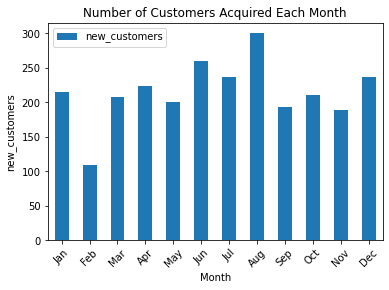

In [17]:
# Plot the bar plot- monthly active customer
plt.figure(figsize=(12,6))
actcustomer_count_by_month_df.plot(x='Month', y='new_customers', kind='bar')

# Add labels and title
plt.xlabel('Month')
plt.ylabel('new_customers')
plt.xticks(rotation=45)
plt.title('Number of Customers Acquired Each Month')
plt.show()

## Monthly Rentention (MRR)-Retention of customers on month basis

In [18]:
Month_shortform_categories=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun','Jul', 'Aug', 'Sep', 'Oct', 'Nov','Dec']
actcustomer_count_by_month=actcustomer_count_by_month.reindex(Month_shortform_categories, axis=0)

In [19]:
#get monthly unique customer list
monthly_unique_customerID_list=distinct_cust_table.groupby('Month')['CustomerID'].unique().to_list()

#get retent customer list, and find duplicated counts
retention_customer_counts=[]
for month in range(len(Month_shortform_categories)):
    if month<1:
        retention_customer_count=0
        
    else: 
        previous_month_set= set(monthly_unique_customerID_list[month-1])
        current_month_set=set(monthly_unique_customerID_list[month])
        retention_customer_list= previous_month_set.intersection(current_month_set)
        retention_customer_count=len(retention_customer_list)
    retention_customer_counts.append(retention_customer_count)

In [20]:
retention_table=pd.DataFrame({'Month': Month_shortform_categories,
                'Retention_Cust': retention_customer_counts,
                'Total_Cust': actcustomer_count_by_month.values})

In [21]:
retention_table=pd.DataFrame({'Month': Month_shortform_categories,
                'Retention_Cust': retention_customer_counts,
                'Total_Cust': actcustomer_count_by_month.values})
retention_table['MRR (%)']=(retention_table['Retention_Cust']/retention_table['Total_Cust']*100).round(2)

In [22]:
#retention_table

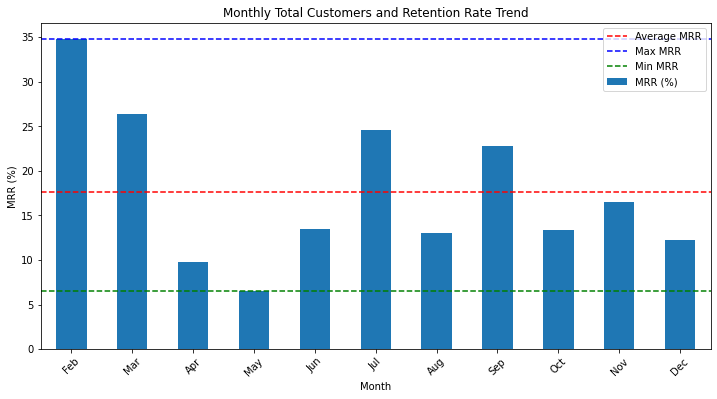

In [23]:
# Filter out the data for January, because retention=0 
retention_table_filtered = retention_table[retention_table['Month'] != 'Jan']

# Plotting for MRR and average MRR
ax= retention_table_filtered.plot(x='Month', y='MRR (%)', kind='bar')
average_mrr = retention_table_filtered['MRR (%)'].mean()
max_mrr = retention_table_filtered['MRR (%)'].max()
min_mrr = retention_table_filtered['MRR (%)'].min()
plt.axhline(y=average_mrr, color='red', linestyle='--', label='Average MRR')
plt.axhline(y=max_mrr, color='blue', linestyle='--', label='Max MRR')
plt.axhline(y=min_mrr, color='green', linestyle='--', label='Min MRR')



# Add labels and title
plt.xlabel('Month')
plt.ylabel('MRR (%)')
plt.title('Monthly Total Customers and Retention Rate Trend')

# Show legend
plt.legend()
plt.gcf().set_size_inches(12, 6)

# Show plot
plt.xticks(rotation=45)
plt.show()

## revenue from existing and new customers on month basis

In [24]:
all_customer_discount_and_price_tax_table['Revenue']= all_customer_discount_and_price_tax_table['Quantity']* all_customer_discount_and_price_tax_table['Avg_Price']* (100- all_customer_discount_and_price_tax_table['Discount_pct'])/100

In [24]:
old_revenue=[]
new_revenue=[]
old_CPI=[]
new_CPI=[]

accumulate_list=[]
for ind, month in enumerate(Month_shortform_categories):
    accumulate_list=Month_shortform_categories[:ind]

    # get previous months' all customerID
    all_old_month_transaction= all_customer_discount_and_price_tax_table[
        all_customer_discount_and_price_tax_table['Month'].isin(accumulate_list)]['CustomerID'].unique().tolist() #old
    # get this months' customerID
    new_month_transaction= all_customer_discount_and_price_tax_table[
        all_customer_discount_and_price_tax_table['Month']==month]['CustomerID'].unique().tolist()

    old_set= set(all_old_month_transaction)
    new_plus_old_set= set(new_month_transaction)

    #get old and new customerID for the month
    old_customers= new_plus_old_set.intersection(old_set)
    n_old_customers= len(old_customers)
    new_customers= new_plus_old_set-old_customers
    n_new_customers= len(new_customers)
    
    #calculate revenue and purchase power indicator (CPI) for old and new customerID 
    new_customer_revenue= all_customer_discount_and_price_tax_table[
        (all_customer_discount_and_price_tax_table['CustomerID'].isin(new_customers)) &
        (all_customer_discount_and_price_tax_table['Month'] == month)]['Revenue'].sum()
    new_customer_CPI= new_customer_revenue/n_new_customers

    old_customer_revenue= all_customer_discount_and_price_tax_table[
        (all_customer_discount_and_price_tax_table['CustomerID'].isin(old_customers)) &
        (all_customer_discount_and_price_tax_table['Month'] == month)]['Revenue'].sum()
    old_customer_CPI= old_customer_revenue/n_old_customers

    old_revenue.append(old_customer_revenue)
    new_revenue.append(new_customer_revenue)
    old_CPI.append(old_customer_CPI)
    new_CPI.append(new_customer_CPI)


<ipython-input-24-cf132bf22129>:35: RuntimeWarning: invalid value encountered in double_scalars
  old_customer_CPI= old_customer_revenue/n_old_customers


In [25]:
old_new_customer_revenue_CPI_df=pd.DataFrame(
    {"Month": Month_shortform_categories,
    "old_customer_revenue": old_revenue,
    "new_customer_revenue": new_revenue,
    "old_customer_CPI": old_CPI,
    "new_customer_CPI": new_CPI})
old_new_customer_revenue_CPI_df.fillna(0)

Month  old_customer_revenue  new_customer_revenue  old_customer_CPI  \
0    Jan                 0.000            390151.310          0.000000   
1    Feb             36313.494            254593.492       2793.345692   
2    Mar             48053.172            265314.094       1550.102323   
3    Apr            162412.416            223949.711       2662.498623   
4    May            103661.206            184281.168       1177.968250   
5    Jun            114164.125            174352.210        935.771516   
6    Jul            215296.863            144274.533       1516.175092   
7    Aug            194075.566            178456.928       1176.215552   
8    Sep            190496.194            129935.406       1656.488643   
9    Oct            185907.105            210082.250       1511.439878   
10   Nov            271651.988            201504.064       2263.766567   
11   Dec            249697.001            222983.946       1920.746162   

    new_customer_CPI  
0        1814.657256  
1        2652.015542  
2        1498.949684  
3        1373.924607  
4        1645.367571  
5        1272.643869  
6        1534.835457  
7        1321.903170  
8        1665.838538  
9        2414.738506  
10       2963.295059  
11       2103.622132

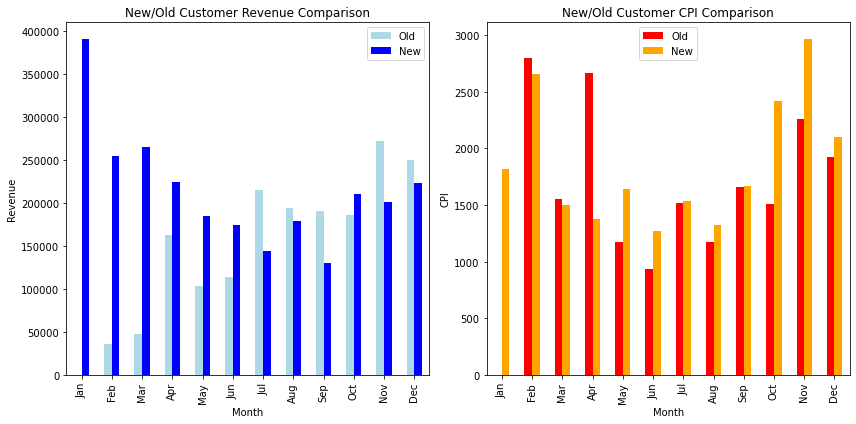

In [26]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Plot the first bar plot on the first subplot
old_new_customer_revenue_CPI_df.plot(x='Month', 
                                     y=['old_customer_revenue','new_customer_revenue'], 
                                     kind='bar', ax=axes[0],
                                     color=['lightblue', 'blue'])
axes[0].set_title('New/Old Customer Revenue Comparison')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Revenue')
axes[0].legend(['Old', 'New'])

# Plot the second bar plot on the second subplot
old_new_customer_revenue_CPI_df.plot(x='Month', 
                                     y=['old_customer_CPI','new_customer_CPI'], 
                                     kind='bar', ax=axes[1],
                                     color=['red', 'orange'])
axes[1].set_title('New/Old Customer CPI Comparison')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('CPI')
axes[1].legend(['Old', 'New'])

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

## how does the discount play as a role in revenue?

In [30]:
discount_and_revenue_df =all_customer_discount_and_price_tax_table[
    ['CustomerID', 'Gender', 'Location', 'Tenure_Months', 'Month', 'Product_Category', 'Quantity', 'Avg_Price', 'Coupon_Status', 'Discount_pct', 'Revenue']
]

### (A) Purchase and Revenue composition in different Coupon usage 

In [87]:
import matplotlib.colors as mcolors
css_colors = list(mcolors.CSS4_COLORS.keys())
#css_colors

details about the color code, see: https://matplotlib.org/stable/gallery/color/named_colors.html (CSS Colors section)

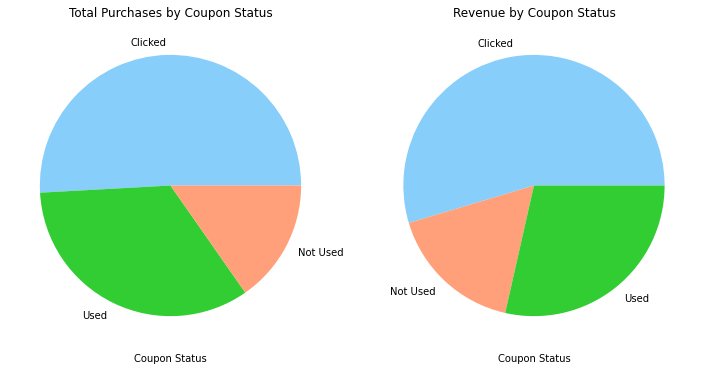

In [62]:
#Define Fixed colors for charts
colors = {'Clicked': css_colors[77], 'Used': css_colors[83], 'Not Used': css_colors[75]}


fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot the pie chart for total purchases
coupon_in_total_purchase = discount_and_revenue_df['Coupon_Status'].value_counts()
coupon_in_total_purchase.index = ['Clicked', 'Used', 'Not Used']
coupon_in_total_purchase.plot(kind='pie', colors=[colors.get(x, '#999999') for x in coupon_in_total_purchase.index], ax=axs[0])
axs[0].set_title('Total Purchases by Coupon Status')
axs[0].set_ylabel('')
axs[0].set_xlabel('Coupon Status')

# Plot the pie chart for revenue
revenue_by_coupon_status = discount_and_revenue_df.groupby('Coupon_Status')['Revenue'].sum()
revenue_by_coupon_status.plot(kind='pie', colors=[colors.get(x, '#999999') for x in revenue_by_coupon_status.index], ax=axs[1])
axs[1].set_title('Revenue by Coupon Status')
axs[1].set_ylabel('')
axs[1].set_xlabel('Coupon Status')

# Plotting
plt.tight_layout()
plt.show()

### (B) Product Category distribution under different Coupon usages

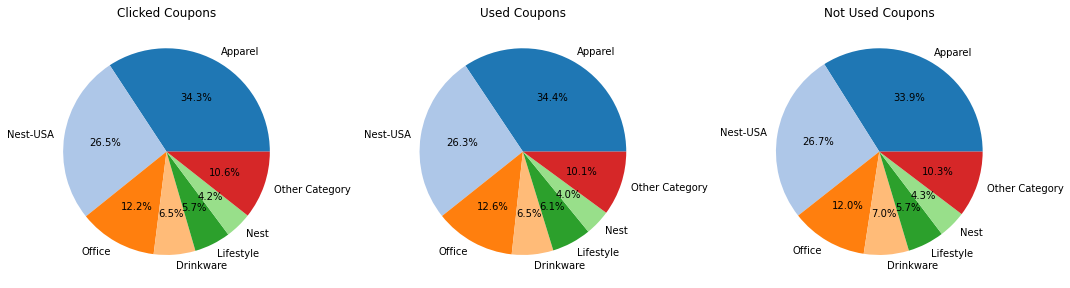

In [80]:
# if the category<0.04, shown & aggregate as OTHER
label_threshold = 0.04

#plot definition
colors = plt.cm.tab20.colors[:len(discount_and_revenue_df['Product_Category'].unique())]
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot 3 pie
for i, coupon_status in enumerate(['Clicked', 'Used', 'Not Used']):
    # Filter the DataFrame for the current coupon status
    coupon_status_df = discount_and_revenue_df[discount_and_revenue_df['Coupon_Status'] == coupon_status]
    
    #counts for different category and filtered by threshold
    product_category_counts = coupon_status_df['Product_Category'].value_counts(normalize=True)
    other_category_percentage = product_category_counts[product_category_counts <= label_threshold].sum()
    product_category_counts = product_category_counts[product_category_counts > label_threshold]
    
    product_category_counts['Other Category'] = other_category_percentage
    
    # Plot the pie chart
    product_category_counts.plot(kind='pie', ax=axs[i], autopct='%1.1f%%', colors=colors)
    axs[i].set_title(f'{coupon_status} Coupons')
    axs[i].set_ylabel('')
    axs[i].set_xlabel('')
    
# Plotting
plt.tight_layout()
plt.show()

### (C) Gender distribution under different Coupon usage

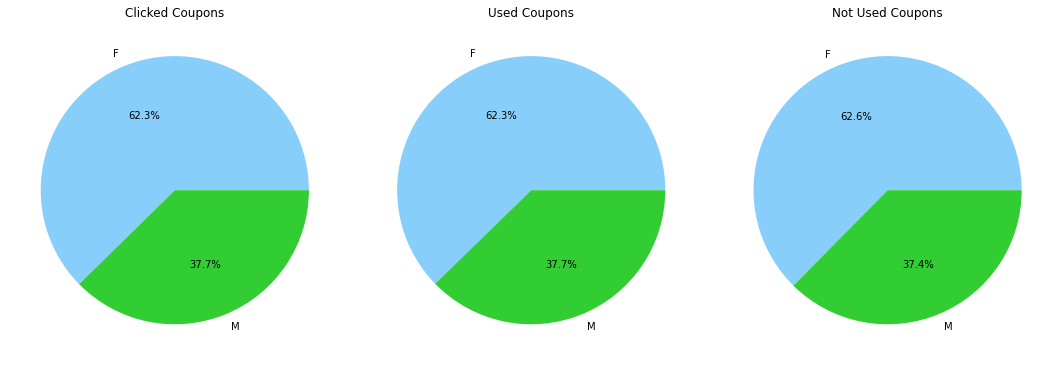

In [95]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot 3 pie charts
for i, coupon_status in enumerate(['Clicked', 'Used', 'Not Used']):
    # Filter the DataFrame for the current coupon status
    coupon_status_df = discount_and_revenue_df[discount_and_revenue_df['Coupon_Status'] == coupon_status]
    
    # Calculate counts for different categories and filter by threshold
    product_category_counts = coupon_status_df['Gender'].value_counts(normalize=True)
    
    # Plot the pie chart
    product_category_counts.plot(kind='pie', ax=axs[i], autopct='%1.1f%%', 
                                 colors=['lightskyblue', 'limegreen'])
    axs[i].set_title(f'{coupon_status} Coupons')
    axs[i].set_ylabel('')
    axs[i].set_xlabel('')

plt.tight_layout()
plt.show()

### (D) Customers' Demographics info distribution under diffferent Coupon usage

/Users/christina/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1583: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  results = ax.pie(y, labels=blabels, **kwds)


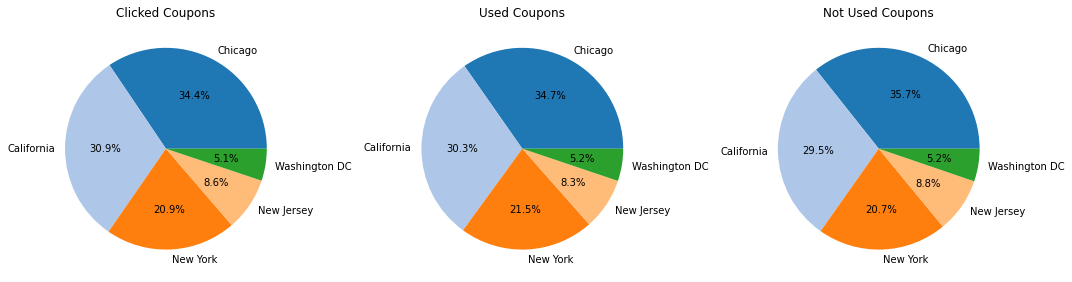

In [97]:
# if the category<0.04, shown & aggregate as OTHER
label_threshold = 0.04

#plot definition
colors = plt.cm.tab20.colors[:len(discount_and_revenue_df['Location'].unique())]
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot 3 pie
for i, coupon_status in enumerate(['Clicked', 'Used', 'Not Used']):
    # Filter the DataFrame for the current coupon status
    coupon_status_df = discount_and_revenue_df[discount_and_revenue_df['Coupon_Status'] == coupon_status]
    
    #counts for different category and filtered by threshold
    product_category_counts = coupon_status_df['Location'].value_counts(normalize=True)
    other_category_percentage = product_category_counts[product_category_counts <= label_threshold].sum()
    product_category_counts = product_category_counts[product_category_counts > label_threshold]

    
    # Plot the pie chart
    product_category_counts.plot(kind='pie', ax=axs[i], autopct='%1.1f%%', colors=colors)
    axs[i].set_title(f'{coupon_status} Coupons')
    axs[i].set_ylabel('')
    axs[i].set_xlabel('')
    
# Plotting
plt.tight_layout()
plt.show()

### (E) Customer Type Distribution under different Coupon Usages

In [106]:
#Define the intervals for categorization
bins = [0, 6, 12, 18, 24, 30, 36, 42, 48, float('inf')]  # The last bin includes values greater than 24
category_counts = pd.cut(discount_and_revenue_df['Tenure_Months'].unique(), 
                         bins=bins, 
                         labels=['<= 0.5 Year', '<= 1 Year', '<= 1.5 Year', '<= 2 Year', 
                                 '<= 2.5 Year', '<= 3 Year', '<= 3.5 Year', '<= 4 Year', '> 4 Year']).value_counts()


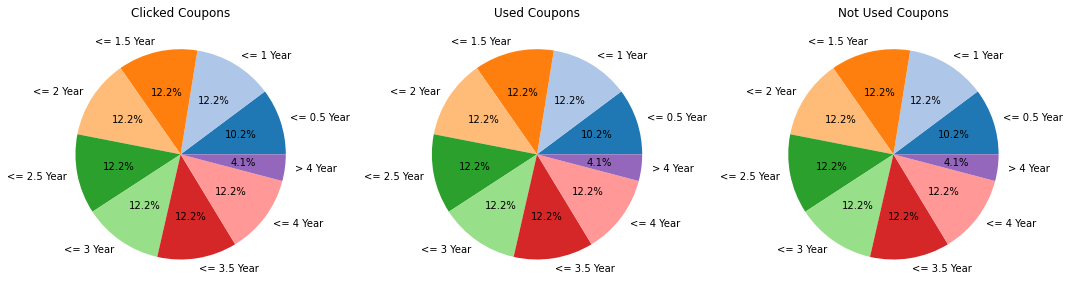

In [114]:
# if the category<0.04, shown & aggregate as OTHER
label_threshold = 0.04

#plot definition
bins = [0, 6, 12, 18, 24, 30, 36, 42, 48, float('inf')]  # The last bin includes values greater than 48


fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot 3 pie
for i, coupon_status in enumerate(['Clicked', 'Used', 'Not Used']):
    # Filter the DataFrame for the current coupon status
    coupon_status_df = discount_and_revenue_df[discount_and_revenue_df['Coupon_Status'] == coupon_status]
    
    #counts for different category and filtered by threshold
    tenure_range_counts = pd.cut(coupon_status_df['Tenure_Months'].unique(), 
                         bins=bins, 
                         labels=['<= 0.5 Year', '<= 1 Year', '<= 1.5 Year', '<= 2 Year', 
                                 '<= 2.5 Year', '<= 3 Year', '<= 3.5 Year', '<= 4 Year', '> 4 Year']).value_counts()
#     other_category_percentage = tenure_range_counts[tenure_range_counts <= label_threshold].sum()
#     tenure_range_counts = tenure_range_counts[tenure_range_counts > label_threshold]

    
    # Plot the pie chart
    colors = plt.cm.tab20.colors[:len(tenure_range_counts)]
    tenure_range_counts.plot(kind='pie', ax=axs[i], autopct='%1.1f%%', colors=colors)
    axs[i].set_title(f'{coupon_status} Coupons')
    axs[i].set_ylabel('')
    axs[i].set_xlabel('')
    
# Plotting
plt.tight_layout()
plt.show()

## KPIs (revenue, number of orders, average order value, number of customers, quantity) by category, by month, by week, etc

### Monthly KPIs

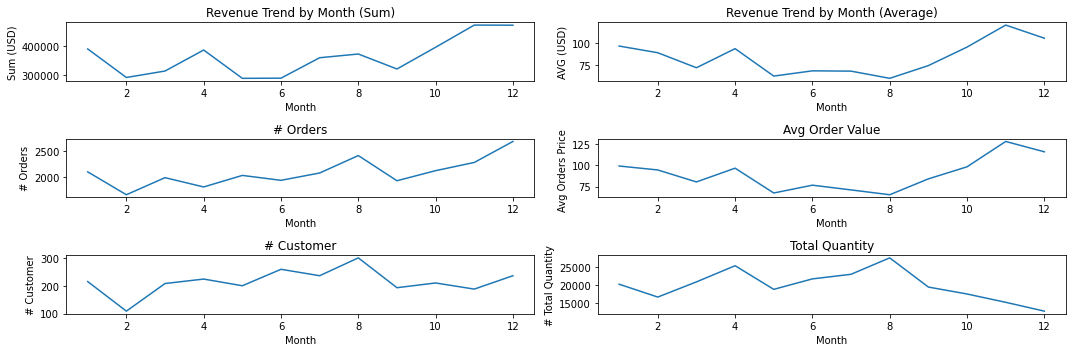

In [210]:
fig, axs = plt.subplots(3, 2, figsize=(15, 5))
#sum revenue 
month_timeseries_revenue_sum = round(month_timeseries_revenue_Df['sum_revenue'], 2)
month_timeseries_revenue_sum.plot(x='Month', y='Revenue', kind='line', ax=axs[0,0])
axs[0,0].set_title('Revenue Trend by Month (Sum)')
axs[0,0].set_xlabel('Month')
axs[0,0].set_ylabel('Sum (USD)')

# Avg revenue
month_timeseries_revenue_avg = round(month_timeseries_revenue_Df['avg_revenue'], 2)
month_timeseries_revenue_avg.plot(x='Month', y='Revenue', kind='line', ax=axs[0,1])
axs[0,1].set_title('Revenue Trend by Month (Average)')
axs[0,1].set_xlabel('Month')
axs[0,1].set_ylabel('AVG (USD)')

#axs[0,0].set_title('Revenue')

###
#number of orders
month_timeseries_norder_sum = round(month_timeseries_revenue_Df['n_orders'], 2)
month_timeseries_norder_sum.plot(x='Month', y='n_orders', kind='line', ax=axs[1,0])
axs[1,0].set_title('# Orders')
axs[1,0].set_xlabel('Month')
axs[1,0].set_ylabel('# Orders')

# Avg revenue
month_timeseries_orderprice_avg = round(month_timeseries_revenue_Df['avg_order_price'], 2)
month_timeseries_orderprice_avg.plot(x='Month', y='avg_order_price', kind='line', ax=axs[1,1])
axs[1,1].set_title('Avg Order Value')
axs[1,1].set_xlabel('Month')
axs[1,1].set_ylabel('Avg Orders Price ')

#axs[1,0].set_title('Order')
###
#number of orders
month_timeseries_ncustomer_sum = round(month_timeseries_revenue_Df['n_customers'], 2)
month_timeseries_ncustomer_sum.plot(x='Month', y='n_customers', kind='line', ax=axs[2,0])
axs[2,0].set_title('# Customer')
axs[2,0].set_xlabel('Month')
axs[2,0].set_ylabel('# Customer')

# Avg revenue
month_timeseries_quantity_avg = round(month_timeseries_revenue_Df['sum_quantity'], 2)
month_timeseries_quantity_avg.plot(x='Month', y='sum_quantity', kind='line', ax=axs[2,1])
axs[2,1].set_title('Total Quantity')
axs[2,1].set_xlabel('Month')
axs[2,1].set_ylabel('# Total Quantity')

plt.tight_layout()
plt.show()

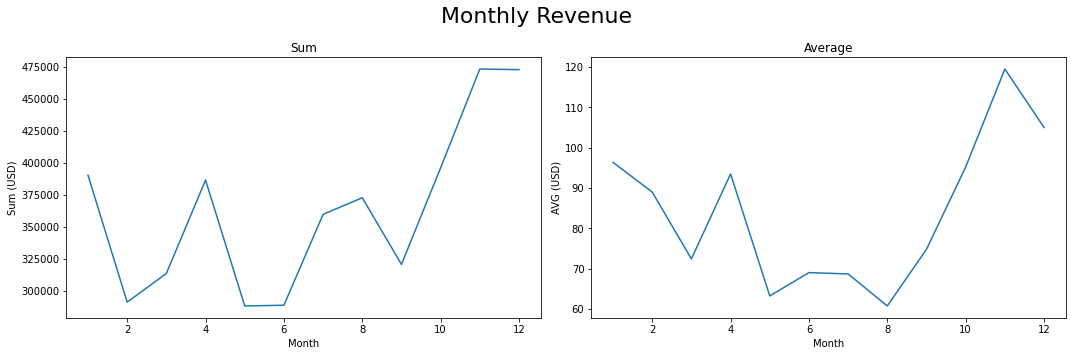

In [207]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
#number of orders
month_timeseries_revenue_sum = round(month_timeseries_revenue_Df['sum_revenue'], 2)
month_timeseries_revenue_sum.plot(x='Month', y='Revenue', kind='line', ax=axs[0])
axs[0].set_title('Sum')
axs[0].set_xlabel('Month')
axs[0].set_ylabel('Sum (USD)')

# Avg revenue
month_timeseries_revenue_avg = round(month_timeseries_revenue_Df['avg_revenue'], 2)
month_timeseries_revenue_avg.plot(x='Month', y='Revenue', kind='line', ax=axs[1])
axs[1].set_title('Average')
axs[1].set_xlabel('Month')
axs[1].set_ylabel('AVG (USD)')

fig.suptitle('Monthly Revenue', fontsize=22)
plt.tight_layout()
plt.show()

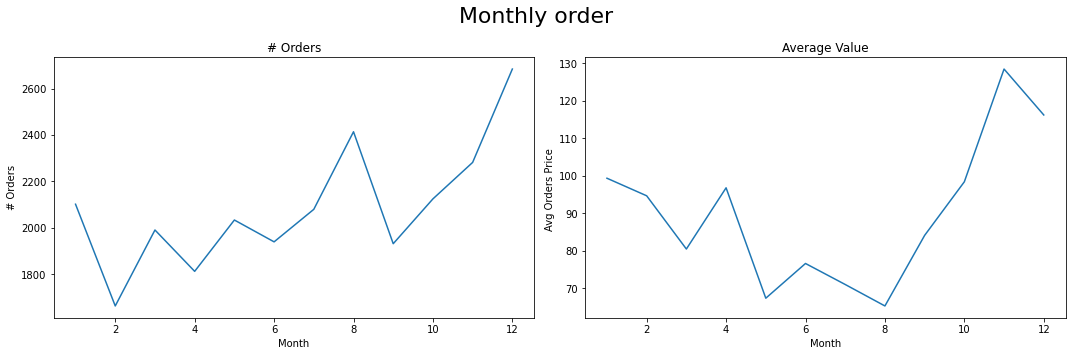

In [208]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
#number of orders
month_timeseries_norder_sum = round(month_timeseries_revenue_Df['n_orders'], 2)
month_timeseries_norder_sum.plot(x='Month', y='n_orders', kind='line', ax=axs[0])
axs[0].set_title('# Orders')
axs[0].set_xlabel('Month')
axs[0].set_ylabel('# Orders')

# Avg revenue
month_timeseries_orderprice_avg = round(month_timeseries_revenue_Df['avg_order_price'], 2)
month_timeseries_orderprice_avg.plot(x='Month', y='avg_order_price', kind='line', ax=axs[1])
axs[1].set_title('Average Value')
axs[1].set_xlabel('Month')
axs[1].set_ylabel('Avg Orders Price ')

fig.suptitle('Monthly order', fontsize=22)
plt.tight_layout()
plt.show()

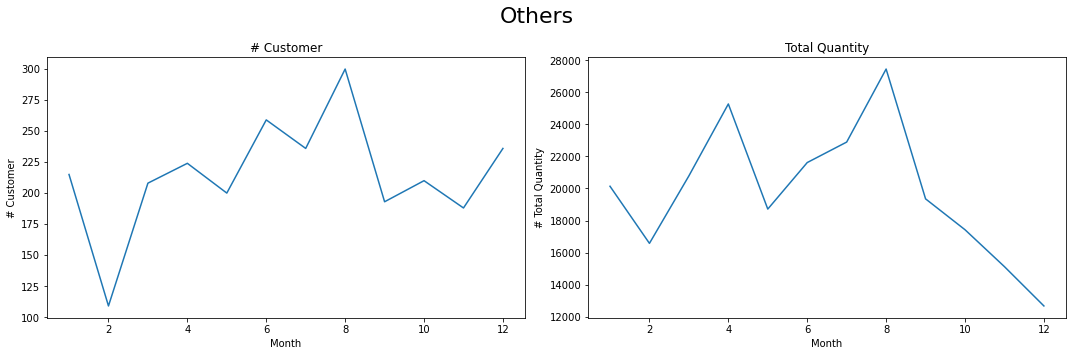

In [211]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
# #Customers
month_timeseries_ncustomer_sum = round(month_timeseries_revenue_Df['n_customers'], 2)
month_timeseries_ncustomer_sum.plot(x='Month', y='n_customers', kind='line', ax=axs[0])
axs[0].set_title('# Customer')
axs[0].set_xlabel('Month')
axs[0].set_ylabel('# Customer')

# Quantity
month_timeseries_quantity_avg = round(month_timeseries_revenue_Df['sum_quantity'], 2)
month_timeseries_quantity_avg.plot(x='Month', y='sum_quantity', kind='line', ax=axs[1])
axs[1].set_title('Total Quantity')
axs[1].set_xlabel('Month')
axs[1].set_ylabel('# Total Quantity')

fig.suptitle('Others', fontsize=22)
plt.tight_layout()
plt.show()

### Weekly KPIs

In [214]:
week_timeseries_revenue_Df=pd.DataFrame(
    {"Week": sorted(all_customer_discount_and_price_tax_table['Transaction_Date'].dt.strftime('%U').unique()),
     "sum_revenue": all_customer_discount_and_price_tax_table.groupby(all_customer_discount_and_price_tax_table['Transaction_Date'].dt.strftime('%U')).apply(lambda x: x['Revenue'].sum()),
     "avg_revenue": all_customer_discount_and_price_tax_table.groupby(all_customer_discount_and_price_tax_table['Transaction_Date'].dt.strftime('%U')).apply(lambda x: x['Revenue'].mean()),
     "n_orders": all_customer_discount_and_price_tax_table.groupby(all_customer_discount_and_price_tax_table['Transaction_Date'].dt.strftime('%U'))['Transaction_ID'].nunique(),
     "avg_order_price": all_customer_discount_and_price_tax_table.groupby(all_customer_discount_and_price_tax_table['Transaction_Date'].dt.strftime('%U')).apply(lambda x: (x['Quantity']*x['Avg_Price']).mean()),
     "n_customers": all_customer_discount_and_price_tax_table.groupby(all_customer_discount_and_price_tax_table['Transaction_Date'].dt.strftime('%U'))['CustomerID'].nunique(),
     "sum_quantity": all_customer_discount_and_price_tax_table.groupby(all_customer_discount_and_price_tax_table['Transaction_Date'].dt.strftime('%U')).apply(lambda x: (x['Quantity']).sum()),
    })

<b> Summary Plot 

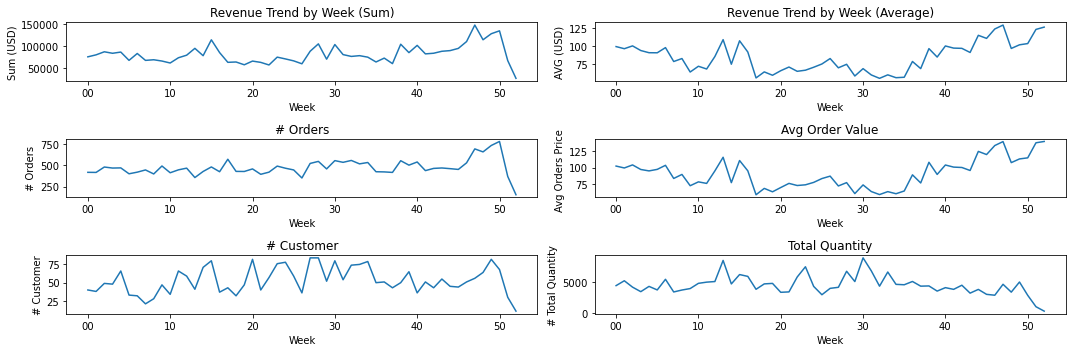

In [215]:
fig, axs = plt.subplots(3, 2, figsize=(15, 5))
#sum revenue 
week_timeseries_revenue_sum = round(week_timeseries_revenue_Df['sum_revenue'], 2)
week_timeseries_revenue_sum.plot(x='Week', y='Revenue', kind='line', ax=axs[0,0])
axs[0,0].set_title('Revenue Trend by Week (Sum)')
axs[0,0].set_xlabel('Week')
axs[0,0].set_ylabel('Sum (USD)')

# Avg revenue
week_timeseries_revenue_avg = round(week_timeseries_revenue_Df['avg_revenue'], 2)
week_timeseries_revenue_avg.plot(x='Week', y='Revenue', kind='line', ax=axs[0,1])
axs[0,1].set_title('Revenue Trend by Week (Average)')
axs[0,1].set_xlabel('Week')
axs[0,1].set_ylabel('AVG (USD)')

#axs[0,0].set_title('Revenue')

###
#number of orders
week_timeseries_norder_sum = round(week_timeseries_revenue_Df['n_orders'], 2)
week_timeseries_norder_sum.plot(x='Week', y='n_orders', kind='line', ax=axs[1,0])
axs[1,0].set_title('# Orders')
axs[1,0].set_xlabel('Week')
axs[1,0].set_ylabel('# Orders')

# Avg revenue
week_timeseries_orderprice_avg = round(week_timeseries_revenue_Df['avg_order_price'], 2)
week_timeseries_orderprice_avg.plot(x='Week', y='avg_order_price', kind='line', ax=axs[1,1])
axs[1,1].set_title('Avg Order Value')
axs[1,1].set_xlabel('Week')
axs[1,1].set_ylabel('Avg Orders Price ')

#axs[1,0].set_title('Order')
###
#number of orders
week_timeseries_ncustomer_sum = round(week_timeseries_revenue_Df['n_customers'], 2)
week_timeseries_ncustomer_sum.plot(x='Week', y='n_customers', kind='line', ax=axs[2,0])
axs[2,0].set_title('# Customer')
axs[2,0].set_xlabel('Week')
axs[2,0].set_ylabel('# Customer')

# Avg revenue
week_timeseries_quantity_avg = round(week_timeseries_revenue_Df['sum_quantity'], 2)
week_timeseries_quantity_avg.plot(x='Week', y='sum_quantity', kind='line', ax=axs[2,1])
axs[2,1].set_title('Total Quantity')
axs[2,1].set_xlabel('Week')
axs[2,1].set_ylabel('# Total Quantity')

plt.tight_layout()
plt.show()

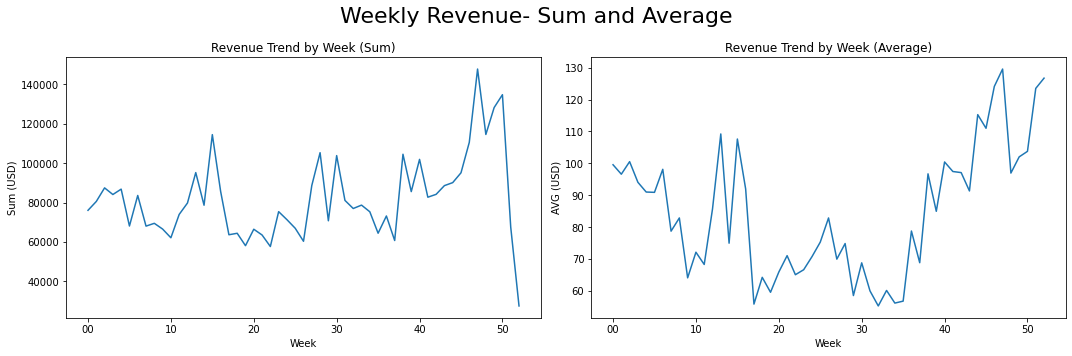

In [163]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Sum revenue
week_timeseries_revenue_sum = round(week_timeseries_revenue_Df.groupby('Week')['Revenue'].sum(), 2)
week_timeseries_revenue_sum.plot(x='Week', y='Revenue', kind='line', ax=axs[0])
axs[0].set_title('Revenue Trend by Week (Sum)')
axs[0].set_xlabel('Week')
axs[0].set_ylabel('Sum (USD)')

# Avg revenue
week_timeseries_revenue_sum = round(week_timeseries_revenue_Df.groupby('Week')['Revenue'].mean(), 2)
week_timeseries_revenue_sum.plot(x='Week', y='Revenue', kind='line', ax=axs[1])
axs[1].set_title('Revenue Trend by Week (Average)')
axs[1].set_xlabel('Week')
axs[1].set_ylabel('AVG (USD)')

# Show the plot
fig.suptitle('Weekly Revenue- Sum and Average', fontsize=22)
plt.tight_layout()
plt.show()

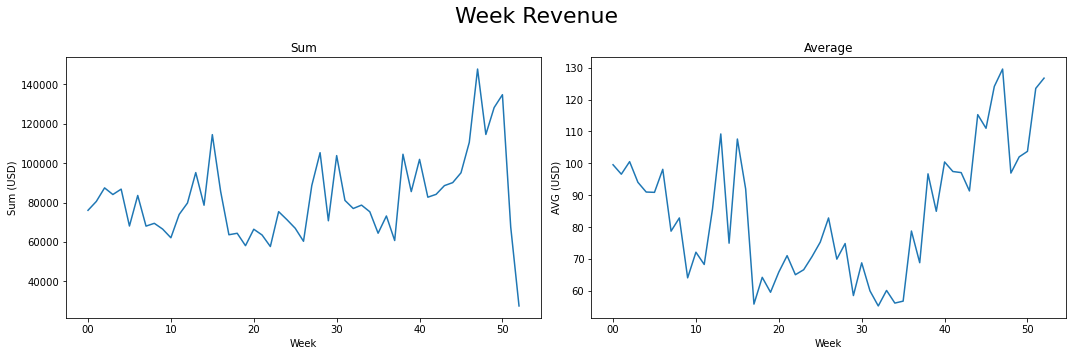

In [216]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
#number of orders
week_timeseries_revenue_sum = round(week_timeseries_revenue_Df['sum_revenue'], 2)
week_timeseries_revenue_sum.plot(x='Week', y='Revenue', kind='line', ax=axs[0])
axs[0].set_title('Sum')
axs[0].set_xlabel('Week')
axs[0].set_ylabel('Sum (USD)')

# Avg revenue
week_timeseries_revenue_avg = round(week_timeseries_revenue_Df['avg_revenue'], 2)
week_timeseries_revenue_avg.plot(x='Week', y='Revenue', kind='line', ax=axs[1])
axs[1].set_title('Average')
axs[1].set_xlabel('Week')
axs[1].set_ylabel('AVG (USD)')

fig.suptitle('Week Revenue', fontsize=22)
plt.tight_layout()
plt.show()

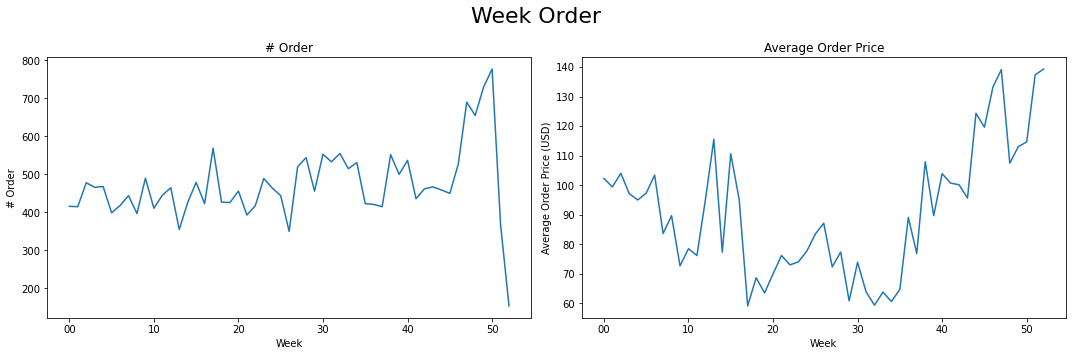

In [218]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
#number of orders
week_timeseries_norder_sum = round(week_timeseries_revenue_Df['n_orders'], 2)
week_timeseries_norder_sum.plot(x='Week', y='n_orders', kind='line', ax=axs[0])
axs[0].set_title('# Order')
axs[0].set_xlabel('Week')
axs[0].set_ylabel('# Order')

# Avg revenue
week_timeseries_orderprice_avg = round(week_timeseries_revenue_Df['avg_order_price'], 2)
week_timeseries_orderprice_avg.plot(x='Week', y='avg_order_price', kind='line', ax=axs[1])
axs[1].set_title('Average Order Price')
axs[1].set_xlabel('Week')
axs[1].set_ylabel('Average Order Price (USD)')

fig.suptitle('Week Order', fontsize=22)
plt.tight_layout()
plt.show()

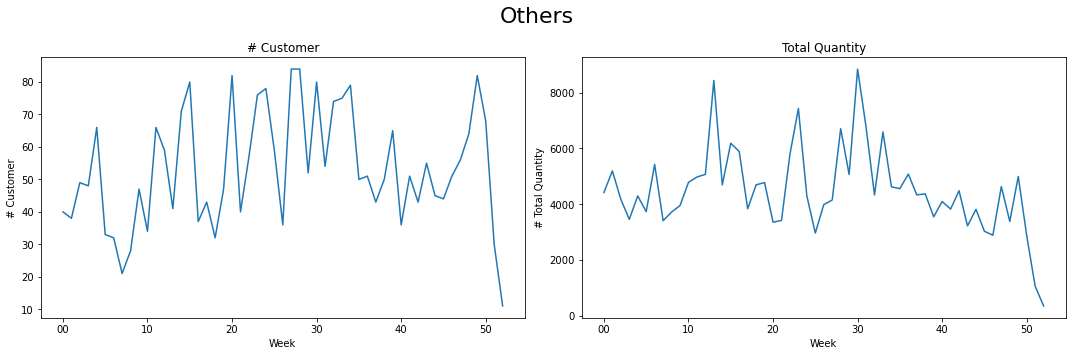

In [219]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
# #Customers
week_timeseries_ncustomer_sum = round(week_timeseries_revenue_Df['n_customers'], 2)
week_timeseries_ncustomer_sum.plot(x='Week', y='n_customers', kind='line', ax=axs[0])
axs[0].set_title('# Customer')
axs[0].set_xlabel('Week')
axs[0].set_ylabel('# Customer')

# Quantity
week_timeseries_quantity_avg = round(week_timeseries_revenue_Df['sum_quantity'], 2)
week_timeseries_quantity_avg.plot(x='Week', y='sum_quantity', kind='line', ax=axs[1])
axs[1].set_title('Total Quantity')
axs[1].set_xlabel('Week')
axs[1].set_ylabel('# Total Quantity')

fig.suptitle('Others', fontsize=22)
plt.tight_layout()
plt.show()

### Categories and Time

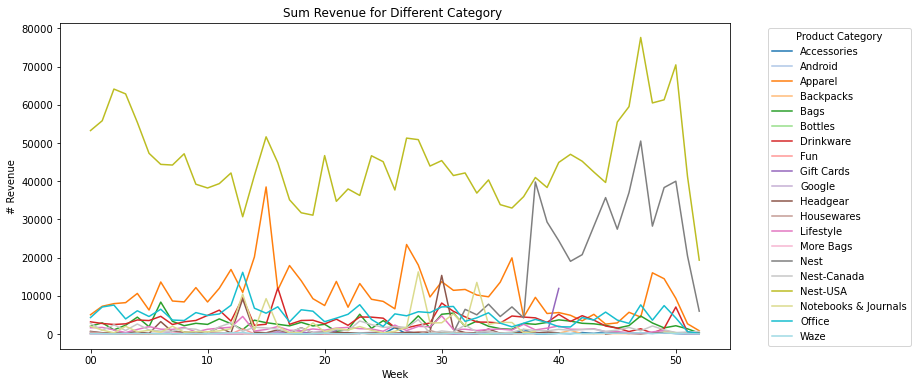

In [240]:
colors = plt.cm.tab20.colors[:len(all_customer_discount_and_price_tax_table['Product_Category'].unique())]
all_customer_discount_and_price_tax_table['Week'] = all_customer_discount_and_price_tax_table['Transaction_Date'].dt.strftime('%U')
#revenue_by_week_category = transaction_table.groupby(['Week', 'Product_Category'])['Revenue'].sum().unstack()
sum_revenue_by_week_category = all_customer_discount_and_price_tax_table.groupby(['Week', 'Product_Category'])['Revenue'].sum().unstack()
sum_revenue_by_week_category.fillna(0)
sum_revenue_by_week_category.plot(kind='line', figsize=(12, 6), color=colors)
plt.title('Sum Revenue for Different Category ')
plt.xlabel('Week')
plt.ylabel('# Revenue')
plt.legend(title='Product Category', bbox_to_anchor=(1.05, 1), loc='upper left')

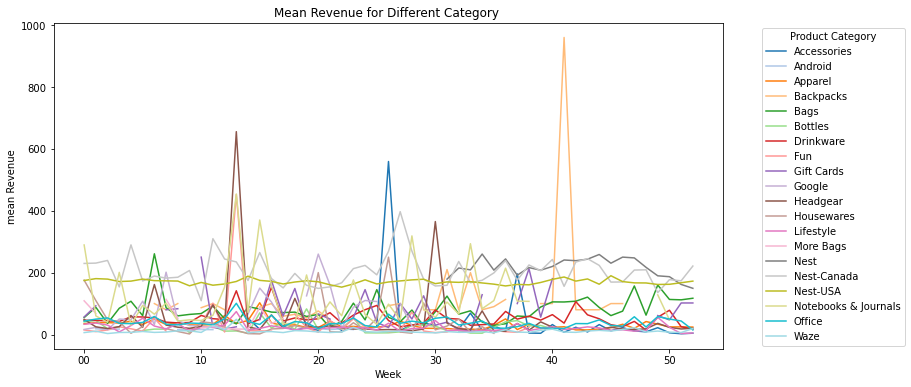

In [242]:
colors = plt.cm.tab20.colors[:len(all_customer_discount_and_price_tax_table['Product_Category'].unique())]
all_customer_discount_and_price_tax_table['Week'] = all_customer_discount_and_price_tax_table['Transaction_Date'].dt.strftime('%U')
#revenue_by_week_category = transaction_table.groupby(['Week', 'Product_Category'])['Revenue'].sum().unstack()
sum_revenue_by_week_category = all_customer_discount_and_price_tax_table.groupby(['Week', 'Product_Category'])['Revenue'].mean().unstack()
sum_revenue_by_week_category.fillna(0)
sum_revenue_by_week_category.plot(kind='line', figsize=(12, 6), color=colors)
plt.title('Mean Revenue for Different Category ')
plt.xlabel('Week')
plt.ylabel('mean Revenue')
plt.legend(title='Product Category', bbox_to_anchor=(1.05, 1), loc='upper left')

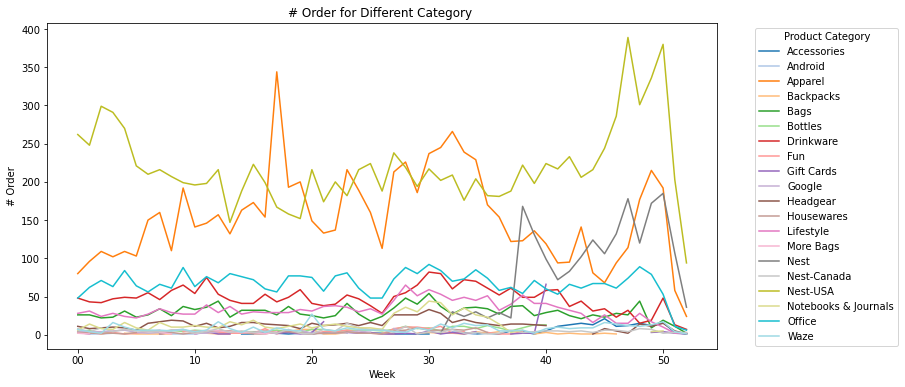

In [243]:
colors = plt.cm.tab20.colors[:len(all_customer_discount_and_price_tax_table['Product_Category'].unique())]
all_customer_discount_and_price_tax_table['Week'] = all_customer_discount_and_price_tax_table['Transaction_Date'].dt.strftime('%U')
#revenue_by_week_category = transaction_table.groupby(['Week', 'Product_Category'])['Revenue'].sum().unstack()
sum_revenue_by_week_category = all_customer_discount_and_price_tax_table.groupby(['Week', 'Product_Category'])['Transaction_ID'].nunique().unstack()
sum_revenue_by_week_category.fillna(0)
sum_revenue_by_week_category.plot(kind='line', figsize=(12, 6), color=colors)
plt.title('# Order for Different Category ')
plt.xlabel('Week')
plt.ylabel('# Order')
plt.legend(title='Product Category', bbox_to_anchor=(1.05, 1), loc='upper left')

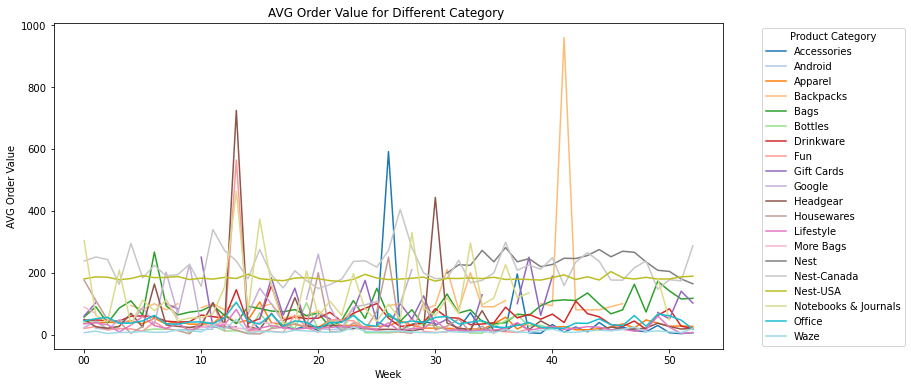

In [249]:
colors = plt.cm.tab20.colors[:len(all_customer_discount_and_price_tax_table['Product_Category'].unique())]
all_customer_discount_and_price_tax_table['Week'] = all_customer_discount_and_price_tax_table['Transaction_Date'].dt.strftime('%U')
#revenue_by_week_category = transaction_table.groupby(['Week', 'Product_Category'])['Revenue'].sum().unstack()
indicator = all_customer_discount_and_price_tax_table.groupby(['Week', 'Product_Category']).apply(lambda x: (x['Quantity']*x['Avg_Price']).mean()).unstack()
indicator.fillna(0)
indicator.plot(kind='line', figsize=(12, 6), color=colors)
plt.title('AVG Order Value for Different Category ')
plt.xlabel('Week')
plt.ylabel('AVG Order Value')
plt.legend(title='Product Category', bbox_to_anchor=(1.05, 1), loc='upper left')

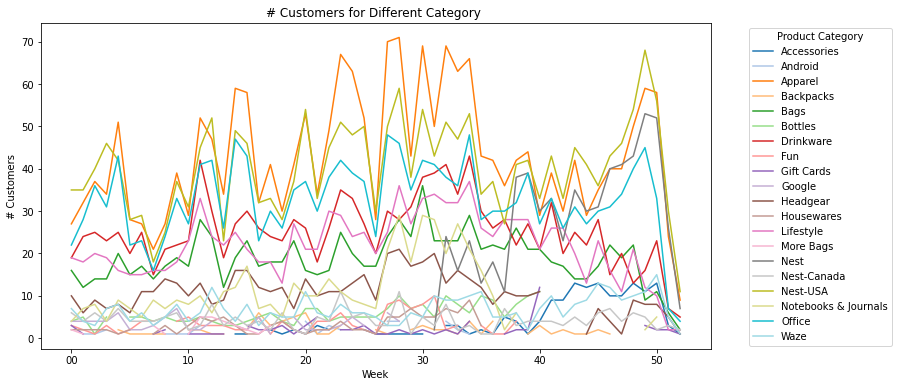

In [251]:
colors = plt.cm.tab20.colors[:len(all_customer_discount_and_price_tax_table['Product_Category'].unique())]
all_customer_discount_and_price_tax_table['Week'] = all_customer_discount_and_price_tax_table['Transaction_Date'].dt.strftime('%U')
#revenue_by_week_category = transaction_table.groupby(['Week', 'Product_Category'])['Revenue'].sum().unstack()
indicator = all_customer_discount_and_price_tax_table.groupby(['Week', 'Product_Category'])['CustomerID'].nunique().unstack()
indicator.fillna(0)
indicator.plot(kind='line', figsize=(12, 6), color=colors)
plt.title('# Customers for Different Category ')
plt.xlabel('Week')
plt.ylabel('# Customers')
plt.legend(title='Product Category', bbox_to_anchor=(1.05, 1), loc='upper left')

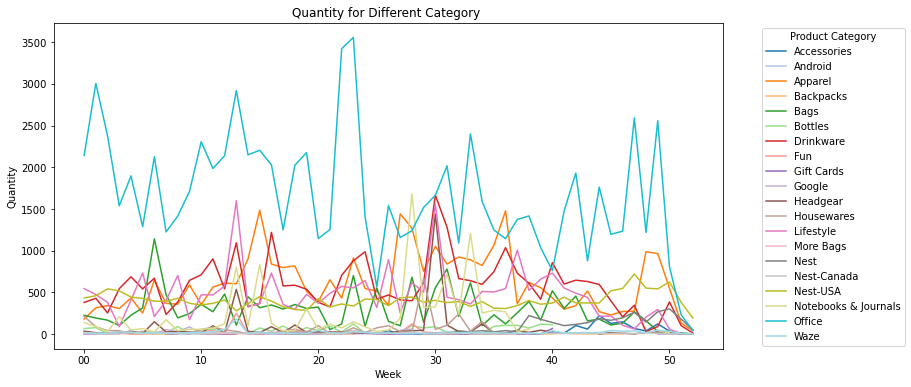

In [252]:
colors = plt.cm.tab20.colors[:len(all_customer_discount_and_price_tax_table['Product_Category'].unique())]
all_customer_discount_and_price_tax_table['Week'] = all_customer_discount_and_price_tax_table['Transaction_Date'].dt.strftime('%U')
#revenue_by_week_category = transaction_table.groupby(['Week', 'Product_Category'])['Revenue'].sum().unstack()
indicator = all_customer_discount_and_price_tax_table.groupby(['Week', 'Product_Category']).apply(lambda x: (x['Quantity']).sum()).unstack()
indicator.fillna(0)
indicator.plot(kind='line', figsize=(12, 6), color=colors)
plt.title('Quantity for Different Category ')
plt.xlabel('Week')
plt.ylabel('Quantity')
plt.legend(title='Product Category', bbox_to_anchor=(1.05, 1), loc='upper left')

## Product Category Clustering 

### clustering

by revenue

In [70]:
sum_revenue_by_day_category = all_customer_discount_and_price_tax_table.groupby(['Transaction_Date', 'Product_Category'])['Revenue'].sum().unstack()
sum_revenue_by_day_category=  sum_revenue_by_day_category.fillna(0)

In [72]:
all_customer_discount_and_price_tax_table['Week'] = all_customer_discount_and_price_tax_table['Transaction_Date'].dt.strftime('%U')
sum_revenue_by_week_category = all_customer_discount_and_price_tax_table.groupby(['Week', 'Product_Category'])['Revenue'].sum().unstack()
sum_revenue_by_week_category = sum_revenue_by_week_category.fillna(0)

by quantity

In [88]:
sum_quantity_by_day_category = all_customer_discount_and_price_tax_table.groupby(['Transaction_Date', 'Product_Category'])['Quantity'].sum().unstack()
sum_quantity_by_day_category=  sum_revenue_by_day_category.fillna(0)

In [89]:
all_customer_discount_and_price_tax_table['Week'] = all_customer_discount_and_price_tax_table['Transaction_Date'].dt.strftime('%U')
sum_quantity_by_week_category = all_customer_discount_and_price_tax_table.groupby(['Week', 'Product_Category'])['Quantity'].sum().unstack()
sum_quantity_by_week_category = sum_revenue_by_week_category.fillna(0)

### t-SNE

In [75]:
from scipy.cluster.hierarchy import linkage, dendrogram

In [90]:
merging= linkage(sum_quantity_by_week_category.T, method="complete")

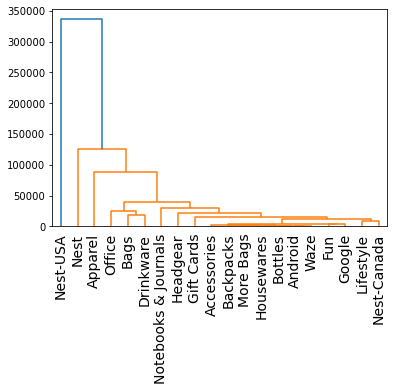

In [118]:
dendrogram(merging, 
          labels= sum_quantity_by_week_category.columns, 
          leaf_rotation=90,
          leaf_font_size=14)
plt.show()

In [96]:
names=list(sum_quantity_by_week_category.columns)

In [107]:
from scipy.cluster.hierarchy import fcluster
labels=fcluster(
  merging, 2500, criterion="distance"
)
pairs = pd.DataFrame({"labels": labels, "category": names})

In [109]:
print(pairs.sort_values(by='labels'))

    labels              category
4        1                  Bags
6        2             Drinkware
18       3                Office
19       4                  Waze
1        4               Android
13       4             More Bags
3        4             Backpacks
5        4               Bottles
11       4            Housewares
0        5           Accessories
7        6                   Fun
9        7                Google
12       8             Lifestyle
15       9           Nest-Canada
8       10            Gift Cards
10      11              Headgear
17      12  Notebooks & Journals
2       13               Apparel
14      14                  Nest
16      15              Nest-USA


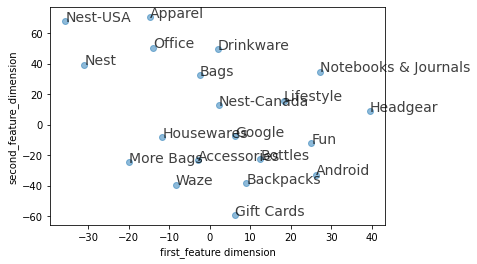

In [120]:
# Import TSNE
from sklearn.manifold import TSNE

# Create a TSNE instance: model
model = TSNE(learning_rate=50, perplexity=10)

# Apply fit_transform to normalized_movements: tsne_features
tsne_features = model.fit_transform(sum_quantity_by_week_category.T)

# Select the 0th feature: xs
xs = tsne_features[:,0]

# Select the 1th feature: ys
ys = tsne_features[:,1]

# Scatter plot
plt.scatter(xs, ys, alpha=0.5)

# Annotate the points
for x, y, cat in zip(xs, ys, names):
    plt.annotate(cat, (x, y), fontsize=14, alpha=0.75)
plt.xlabel('first_feature dimension')
plt.ylabel('second_feature_dimension')
plt.show()


## Decomposition: Seasonality & Trend

In [254]:
from statsmodels.tsa.seasonal import seasonal_decompose

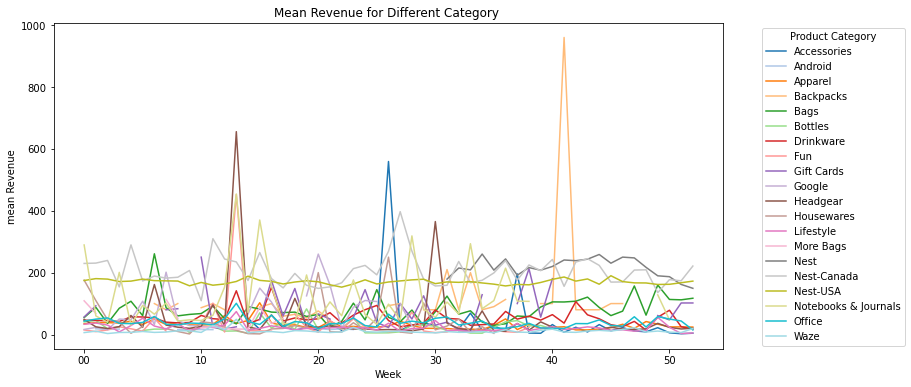

In [317]:
colors = plt.cm.tab20.colors[:len(all_customer_discount_and_price_tax_table['Product_Category'].unique())]
all_customer_discount_and_price_tax_table['Week'] = all_customer_discount_and_price_tax_table['Transaction_Date'].dt.strftime('%U')
#revenue_by_week_category = transaction_table.groupby(['Week', 'Product_Category'])['Revenue'].sum().unstack()
sum_revenue_by_week_category = all_customer_discount_and_price_tax_table.groupby(['Week', 'Product_Category'])['Revenue'].mean().unstack()
sum_revenue_by_week_category.fillna(0)
sum_revenue_by_week_category.plot(kind='line', figsize=(12, 6), color=colors)
plt.title('Mean Revenue for Different Category ')
plt.xlabel('Week')
plt.ylabel('mean Revenue')
plt.legend(title='Product Category', bbox_to_anchor=(1.05, 1), loc='upper left')

In [334]:
all_customer_discount_and_price_tax_table.columns

Index(['CustomerID', 'Gender', 'Location', 'Tenure_Months', 'Transaction_ID',
       'Transaction_Date', 'Product_SKU', 'Product_Description',
       'Product_Category', 'Quantity', 'Avg_Price', 'Delivery_Charges',
       'Coupon_Status', 'Month', 'Coupon_Code', 'Discount_pct', 'GST',
       'Invoice_Value', 'Revenue', 'Week'],
      dtype='object')

In [323]:
sum_revenue_by_week_category.columns

Index(['Accessories', 'Android', 'Apparel', 'Backpacks', 'Bags', 'Bottles',
       'Drinkware', 'Fun', 'Gift Cards', 'Google', 'Headgear', 'Housewares',
       'Lifestyle', 'More Bags', 'Nest', 'Nest-Canada', 'Nest-USA',
       'Notebooks & Journals', 'Office', 'Waze'],
      dtype='object', name='Product_Category')

In [373]:
import matplotlib.dates as mdates

In [389]:
# Trend Decomposition #2month- period 
topic= 'Notebooks & Journals'
test=sum_revenue_by_day_category[topic]
result = seasonal_decompose(test, model='additive', period=30)

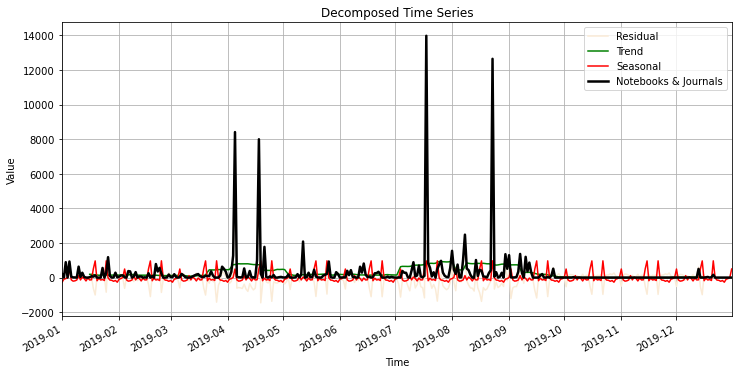

In [390]:
plt.figure(figsize=(20,5))
# Plot trend, seasonal, and residual components

plt.plot(result.resid, color='antiquewhite', label='Residual')
plt.plot(result.trend, color='green', label='Trend')
plt.plot(result.seasonal, color='red', label='Seasonal')
sum_revenue_by_day_category[topic].plot(kind='line', figsize=(12, 6), color='black', linewidth=2.5)

# Add vertical lines at the beginning of each month
locator = mdates.MonthLocator()  # Create a MonthLocator instance
formatter = mdates.DateFormatter('%Y-%m')  # Define the date format for the labels
plt.gca().xaxis.set_major_locator(locator)  # Set the major locator for the x-axis
plt.gca().xaxis.set_major_formatter(formatter)
plt.gca().grid(True)  # Show gridlines
plt.gca().autoscale(enable=True, axis='x', tight=True)  # Autoscale the x-axis
plt.gca().margins(x=0)  # Set margins to zero for tight layout

# Set plot labels and legend
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Decomposed Time Series')
plt.legend()

# Show plot
plt.show()


<b> 7. how many order varies and sales with different days?

## calculate the revenue, marketing spend, percentage of marketing spend out of revenue, tax, pct delivery charges by month (CAC)

In [397]:
marketing_spent['Date']=pd.to_datetime(marketing_spent['Date'], format='%m/%d/%Y')

In [405]:
sf_df=all_customer_discount_and_price_tax_table[[
    'CustomerID','Transaction_ID','Transaction_Date','Revenue'
]]

In [410]:
all_customer_discount_and_price_tax_table.head()

CustomerID Gender Location  Tenure_Months  Transaction_ID Transaction_Date  \
0       17850      M  Chicago             12           16679       2019-01-01   
1       17850      M  Chicago             12           16680       2019-01-01   
2       17850      M  Chicago             12           16681       2019-01-01   
3       17850      M  Chicago             12           16682       2019-01-01   
4       17850      M  Chicago             12           16682       2019-01-01   

      Product_SKU                                Product_Description  \
0  GGOENEBJ079499  Nest Learning Thermostat 3rd Gen-USA - Stainle...   
1  GGOENEBJ079499  Nest Learning Thermostat 3rd Gen-USA - Stainle...   
2  GGOEGFKQ020399              Google Laptop and Cell Phone Stickers   
3  GGOEGAAB010516  Google Men's 100% Cotton Short Sleeve Hero Tee...   
4  GGOEGBJL013999                    Google Canvas Tote Natural/Navy   

  Product_Category  Quantity  Avg_Price  Delivery_Charges Coupon_Status Month  \
0         Nest-USA         1     153.71               6.5          Used   Jan   
1         Nest-USA         1     153.71               6.5          Used   Jan   
2           Office         1       2.05               6.5          Used   Jan   
3          Apparel         5      17.53               6.5      Not Used   Jan   
4             Bags         1      16.50               6.5          Used   Jan   

  Coupon_Code  Discount_pct   GST  Invoice_Value  Revenue Week  
0      ELEC10          10.0  0.10       158.6729  138.339   00  
1      ELEC10          10.0  0.10       158.6729  138.339   00  
2       OFF10          10.0  0.10         8.5295    1.845   00  
3      SALE10           0.0  0.18       109.9270   87.650   00  
4       AIO10          10.0  0.18        24.0230   14.850   00

In [411]:
pct_marketing_revenue= pd.DataFrame({"Total_Revenue": sf_df.groupby(sf_df['Transaction_Date'].dt.month)['Revenue'].sum(),
"Marketing_Cost": marketing_spent.groupby(marketing_spent['Date'].dt.month)['Online_Spend'].sum()})
#Calculate the Revenue, Marketing spend, percentage of marketing spend out of revenue, Tax, percentage of delivery charges by month.

In [416]:
pct_marketing_revenue["Efficiency"]=pct_marketing_revenue["Total_Revenue"]/pct_marketing_revenue["Marketing_Cost"]

In [419]:
month_digit_list=[]
for i in range(1,13):
    month_digit_list.append(i)

In [420]:
pct_marketing_revenue["Month"]=month_digit_list

In [421]:
pct_marketing_revenue

Total_Revenue  Marketing_Cost  Efficiency  Month
1      390151.310        58328.95    6.688811      1
2      290906.986        55807.92    5.212647      2
3      313367.266        48750.09    6.428035      3
4      386362.127        61026.83    6.331021      4
5      287942.374        52759.64    5.457626      5
6      288516.335        53818.14    5.360950      6
7      359571.396        52717.85    6.820676      7
8      372532.494        57404.15    6.489644      8
9      320431.600        52514.54    6.101769      9
10     395989.355        57724.65    6.859970     10
11     473156.052        68144.96    6.943376     11
12     472680.947        76648.75    6.166845     12

<AxesSubplot:xlabel='Month'>

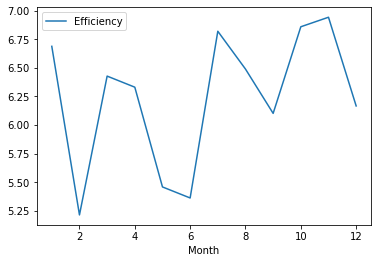

In [422]:
pct_marketing_revenue.plot(x="Month", y="Efficiency" , kind="line")

In [406]:
summary_df=pd.merge(sf_df,marketing_spent,
                    how='left',
                   left_on='Transaction_Date',
                   right_on='Date')

In [407]:
summary_df

CustomerID  Transaction_ID Transaction_Date  Revenue       Date  \
0           17850           16679       2019-01-01  138.339 2019-01-01   
1           17850           16680       2019-01-01  138.339 2019-01-01   
2           17850           16681       2019-01-01    1.845 2019-01-01   
3           17850           16682       2019-01-01   87.650 2019-01-01   
4           17850           16682       2019-01-01   14.850 2019-01-01   
...           ...             ...              ...      ...        ...   
52919       14410           48493       2019-12-31  121.300 2019-12-31   
52920       14410           48494       2019-12-31   34.244 2019-12-31   
52921       14410           48495       2019-12-31  106.316 2019-12-31   
52922       14600           48496       2019-12-31  402.600 2019-12-31   
52923       14600           48497       2019-12-31  322.080 2019-12-31   

       Offline_Spend  Online_Spend  
0               4500       2424.50  
1               4500       2424.50  
2               4500       2424.50  
3               4500       2424.50  
4               4500       2424.50  
...              ...           ...  
52919           4000       2058.75  
52920           4000       2058.75  
52921           4000       2058.75  
52922           4000       2058.75  
52923           4000       2058.75  

[52924 rows x 7 columns]

<b> 9. How marketing spend is impacting on revenue?

<b> 10. Which product was appeared in the transactions?

<b> 11. Which product was purchased mostly based on the quantity?

# Customer Segregation

1. Heuristic (Value based, RFM) – Divide the customers into Premium, Gold, Silver,Standard customers <br> Define strategy on the same.
2. Scientific (Using K-Means) & Understand the profiles. <br> Define strategy for each segment.

## 【Strategy1- Heuristic】get the quantile of the total customer population

In [25]:
rmf_table=copy.deepcopy(all_customer_discount_and_price_tax_table)
reference_day= rmf_table['Transaction_Date'].max()
rmf_table['Recency']=reference_day-rmf_table['Transaction_Date']
rmf_table['Recency']=rmf_table['Recency'].dt.days

In [26]:
all_customer=pd.DataFrame(rmf_table.groupby('CustomerID').apply(lambda x: x['Recency'].min()).reset_index())
all_customer.columns=['CustomerID','Recency']
all_customer.index=all_customer['CustomerID']

In [27]:
all_customer['Purchase_Freq']=rmf_table.groupby('CustomerID').size()
all_customer['Monetary']=rmf_table.groupby('CustomerID').apply(lambda x: x['Revenue'].sum())
all_customer=all_customer.reset_index(drop=True)

In [65]:
all_customer.head()

CustomerID  Recency  Purchase_Freq  Monetary
0       12346      107              2    21.693
1       12347       59             60  9930.649
2       12348       73             23  1142.502
3       12350       17             17   952.049
4       12356      107             36  1009.729

<b> Distribution of Recency, Frequency, Monetary

In [67]:
import seaborn as sns

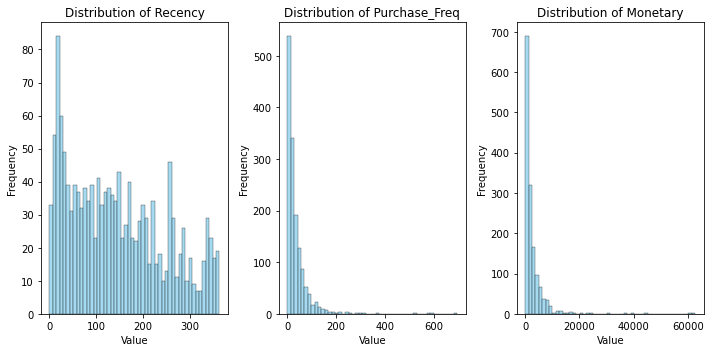

In [69]:
fig, axs= plt.subplots(1, 3, figsize=(10, 5))

#Recency
sns.histplot(data=all_customer, x='Recency', bins=50, color='skyblue', 
             edgecolor='black', ax=axs[0])
axs[0].set_xlabel('Value')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Distribution of Recency')

#Frequency
sns.histplot(data=all_customer, x='Purchase_Freq', bins=50, color='skyblue', 
             edgecolor='black', ax=axs[1])
axs[1].set_xlabel('Value')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Distribution of Purchase_Freq')

#Monetary
sns.histplot(data=all_customer, x='Monetary', bins=50, color='skyblue', 
             edgecolor='black', ax=axs[2])
axs[2].set_xlabel('Value')
axs[2].set_ylabel('Frequency')
axs[2].set_title('Distribution of Monetary')

# Show the plot
plt.tight_layout()
plt.show()

In [71]:
all_customer['Recency_rank']=pd.qcut(all_customer['Recency'], q=3, labels=False)
all_customer['Recency_rank']=2-all_customer['Recency_rank']
#Recency: 2 most recent; 1- middle; 0- least recent
all_customer['Frequncy_rank']=pd.qcut(all_customer['Purchase_Freq'], q=3, labels=False)
#Frequency: 2-most frequent; 1- middle; 0- least frequent
all_customer['Monetary_rank']=pd.qcut(all_customer['Monetary'], q=3, labels=False)
#Monetary: 2-most; 1- middle; 0- least

In [72]:
all_customer['Total_Score']=all_customer['Recency_rank']+all_customer['Frequncy_rank']+all_customer['Monetary_rank']
all_customer['Total_Score_rank']=pd.qcut(all_customer['Total_Score'], q=4, 
                                         labels=['Standard','Silver','Gold','Premium'])
all_customer['Total_Score_rank'].value_counts()

Silver      445
Gold        427
Standard    402
Premium     194
Name: Total_Score_rank, dtype: int64

In [513]:
new_all_customer_demo=pd.merge(customer_demo, all_customer, how='left', on='CustomerID')

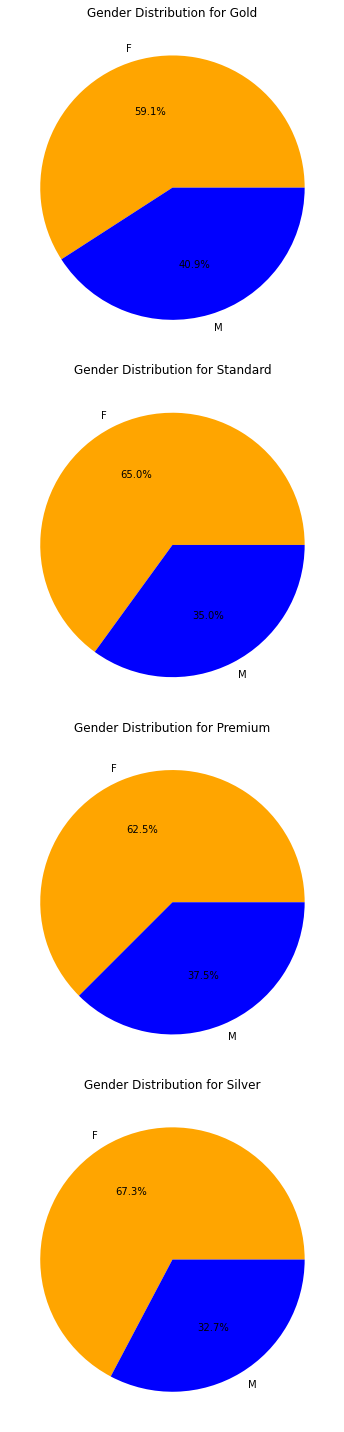

In [546]:
total_score_ranks =new_all_customer_demo['Total_Score_rank'].unique()
colors = {'M': 'blue', 'F': 'orange'}

fig, axs = plt.subplots(len(total_score_ranks), figsize=(15, 5*4))

for i, rank in enumerate(total_score_ranks):
    # Filter data for the current total score rank
    data = new_all_customer_demo[new_all_customer_demo['Total_Score_rank'] == rank]
    gender_counts = data['Gender'].value_counts()
    gender_counts.plot(kind='pie', ax=axs[i], autopct='%1.1f%%',
                       colors=[colors.get(x) for x in gender_counts.index])
    axs[i].set_title(f'Gender Distribution for {rank}')
    axs[i].set_ylabel('')  # Remove y-label for better visualization

# Plotting
plt.tight_layout()
plt.show()

In [552]:
demo_color=['lightsalmon','lightcoral','lemonchiffon','lightskyblue','lightpink']

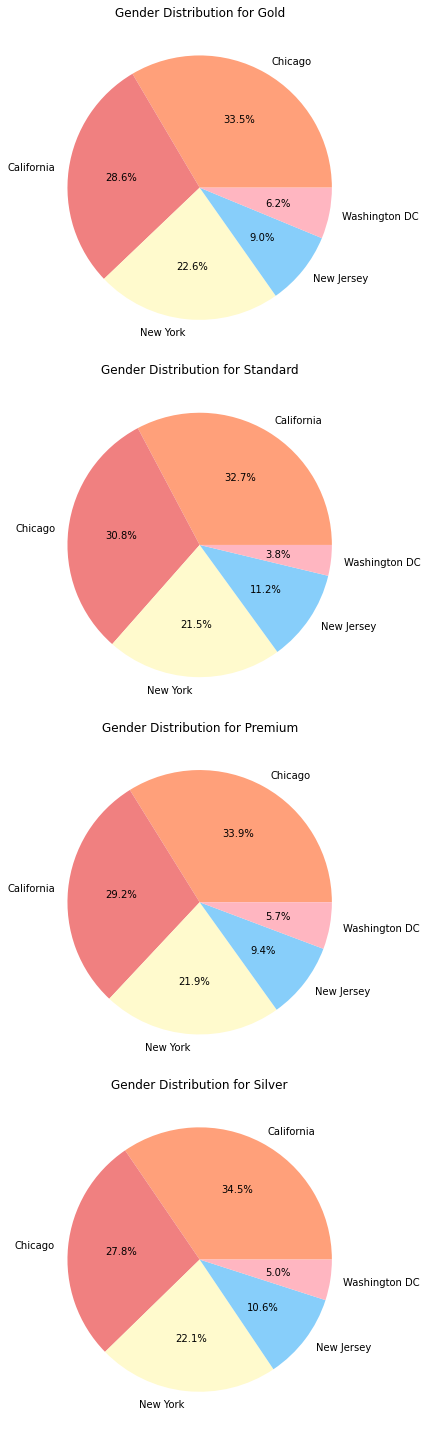

In [553]:
total_score_ranks =new_all_customer_demo['Total_Score_rank'].unique()
#location_counts = data['Location'].value_counts()

fig, axs = plt.subplots(len(total_score_ranks), figsize=(10, 5*4))

for i, rank in enumerate(total_score_ranks):
    # Filter data for the current total score rank
    data = new_all_customer_demo[new_all_customer_demo['Total_Score_rank'] == rank]
    location_counts = data['Location'].value_counts()
    location_counts.plot(kind='pie', ax=axs[i], autopct='%1.1f%%',
                       colors=demo_color)
    axs[i].set_title(f'Gender Distribution for {rank}')
    axs[i].set_ylabel('')  # Remove y-label for better visualization

# Plotting
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Mean Tenure Month in Different Customer Segementation')

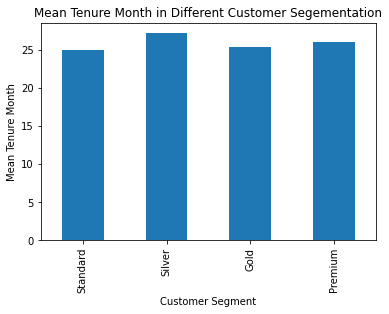

In [548]:
new_all_customer_demo.groupby('Total_Score_rank').apply(lambda x: x['Tenure_Months'].mean()).plot(kind='bar')
plt.ylabel('Mean Tenure Month')
plt.xlabel('Customer Segment')
plt.title('Mean Tenure Month in Different Customer Segementation')

## 【Strategy2-Kmean】

### PCA

In [35]:
# Import Required Packages
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [ ]:
from sklearn.decomposition import PCA
model= PCA()
model.fit(samples)
features= model.n_components_
plt.xticks(features)
plt.ylabel('variance')
plt.xlabel('PCA features')
plt.show()

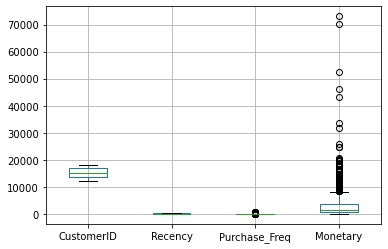

In [36]:
rmf_data.boxplot()
plt.show()

In [41]:
#scaling and normalization
scaler=StandardScaler()
scaled_data= scaler.fit_transform(rmf_data_df)

In [44]:
rmf_data.columns[1:]

Index(['Recency', 'Purchase_Freq', 'Monetary'], dtype='object')

In [45]:
scaled_data=pd.DataFrame(scaled_data, columns=rmf_data.columns[1:])

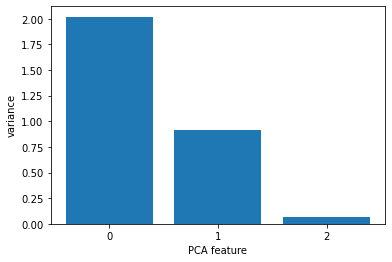

In [46]:
#prepprocessing
pca= PCA()
pca.fit(scaled_data)
n_components= sum(pca.explained_variance_ratio_>0.1)

# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_)
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.xticks(features)
plt.show()

/Users/christina/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/christina/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/christina/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/christina/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of

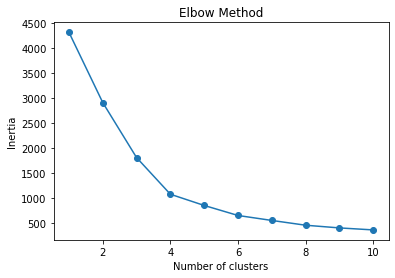

In [50]:
pca=PCA(n_components= n_components)
rmf_data_PCA= pca.fit_transform(scaled_data)

#KMeans
inertias=[]
for k in range(1,11):
    kmeans= KMeans(n_clusters=k, random_state=42).fit(rmf_data_PCA)
    inertias.append(kmeans.inertia_)   
    
plt.plot(range(1, 11), inertias, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()
#n_cluster=4

In [61]:
n_cluster=4

In [62]:
xs= rmf_data_PCA[:,0]
ys= rmf_data_PCA[:,1]
print(rmf_data_PCA.shape)

(1468, 2)


/Users/christina/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


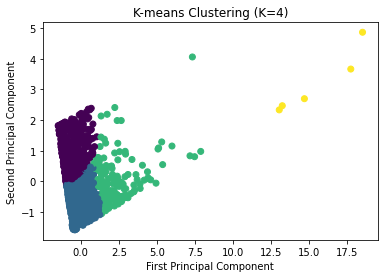

In [63]:
kmeans= KMeans(n_clusters=4, random_state=42).fit(rmf_data_PCA)
labels= kmeans.labels_
plt.scatter(xs, ys, c= labels)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title(f'K-means Clustering (K={4})')
#plt.legend()
plt.show()

In [66]:
rmf_data.head()

CustomerID  Recency  Purchase_Freq   Monetary
0       12346      107              2     21.693
1       12347       59             60  13053.352
2       12348       73             23   1311.415
3       12350       17             17   1207.853
4       12356      107             36   1235.722

In [67]:
rmf_data['cluster']= labels
numeric_cols= ['Recency', 'Purchase_Freq', 'Monetary']
stat_rmf=rmf_data.groupby('cluster')[numeric_cols].mean()
print(stat_rmf)

            Recency  Purchase_Freq      Monetary
cluster                                         
0        254.679417      20.695811   1570.446158
1         77.664908      26.167546   2094.341152
2         83.243590     120.352564  10418.175346
3         29.200000     590.400000  57020.254800


### KMeans 

In [36]:
from sklearn.cluster import KMeans
import warnings

In [50]:
rmf_data = all_customer[['CustomerID', 'Recency', 'Purchase_Freq', 'Monetary']]

In [52]:
data = all_customer[['CustomerID','Recency', 'Purchase_Freq', 'Monetary']].iloc[:,1:]

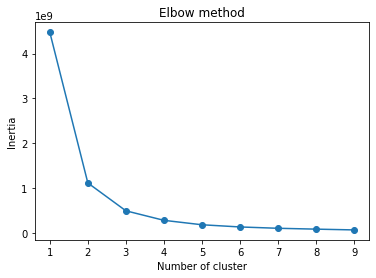

In [47]:
sse={} # error
warnings.filterwarnings("ignore")
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k).fit(data.values)
    data["clusters"] = kmeans.labels_  #cluster names corresponding to recency values 
    sse[k] = kmeans.inertia_ #sse corresponding to clusters
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()), marker='o')
plt.xlabel("Number of cluster")
plt.title('Elbow method')
plt.ylabel('Inertia')
plt.show()

In [54]:
#build 4 clusters for recency and add it to dataframe
kmeans = KMeans(n_clusters=4)
rmf_data['kmean_cluster'] = kmeans.fit_predict(data)

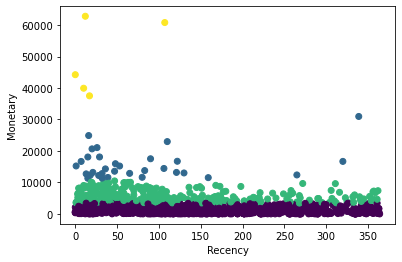

In [56]:
plt.scatter(rmf_data['Recency'],rmf_data['Monetary'], c=rmf_data['kmean_cluster'])
plt.xlabel('Recency')
plt.ylabel('Monetary')
plt.show()

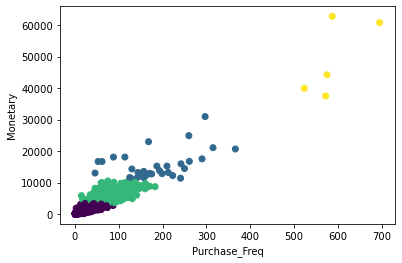

In [57]:
plt.scatter(rmf_data['Purchase_Freq'],rmf_data['Monetary'], c=rmf_data['kmean_cluster'])
plt.xlabel('Purchase_Freq')
plt.ylabel('Monetary')
plt.show()

In [61]:
rmf_data.groupby('kmean_cluster')[['Recency','Purchase_Freq','Monetary']].describe()

Recency                                                    \
                count        mean         std  min    25%    50%    75%   
kmean_cluster                                                             
0              1142.0  154.076182  100.776113  0.0  69.00  144.0  228.0   
1                32.0   77.687500   86.443880  1.0  20.75   43.0  107.0   
2               289.0  114.996540   99.497086  1.0  36.00   82.0  171.0   
3                 5.0   29.200000   43.928351  0.0  10.00   12.0   17.0   

                     Purchase_Freq              ...                Monetary  \
                 max         count        mean  ...     75%    max    count   
kmean_cluster                                   ...                           
0              364.0        1142.0   19.344133  ...   28.00   87.0   1142.0   
1              339.0          32.0  184.906250  ...  241.25  366.0     32.0   
2              362.0         289.0   76.000000  ...   94.00  183.0    289.0   
3              107.0           5.0  590.400000  ...  587.00  695.0      5.0   

                                                                               \
                       mean           std        min          25%         50%   
kmean_cluster                                                                   
0               1158.333822    934.624730      0.900    383.00400    926.4285   
1              15596.348750   4479.350925  11321.746  12636.47625  14039.7910   
2               5710.975893   1816.096038   3443.256   4187.54200   5191.8310   
3              49058.965800  11902.283901  37516.112  39932.32300  44238.0200   

                                       
                       75%        max  
kmean_cluster                          
0               1793.04875   3431.307  
1              16930.32750  30964.878  
2               6905.37600  10483.868  
3              60803.80700  62804.567  

[4 rows x 24 columns]

In [74]:
ct= pd.crosstab(rmf_data['kmean_cluster'], all_customer['Total_Score_rank'])
ct

Total_Score_rank  Standard  Silver  Gold  Premium
kmean_cluster                                    
0                      402     438   262       40
1                        0       0    12       20
2                        0       7   152      130
3                        0       0     1        4

### Standardized KMeans Pipeline

In [76]:
#combining standardization and KMeans using pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
scaler= StandardScaler()
kmeans= KMeans(n_clusters=4)

from sklearn.pipeline import make_pipeline
pipeline=  make_pipeline(scaler, kmeans)
pipeline.fit(data)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kmeans', KMeans(n_clusters=4))])

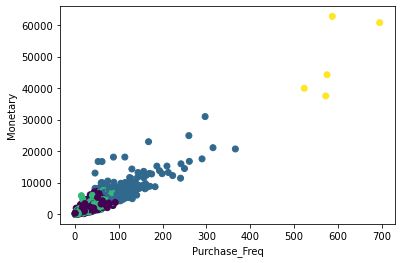

In [77]:
rmf_data['std_kmean_cluster']= pipeline.predict(data)
plt.scatter(rmf_data['Purchase_Freq'],rmf_data['Monetary'], c=rmf_data['std_kmean_cluster'])
plt.xlabel('Purchase_Freq')
plt.ylabel('Monetary')
plt.show()

In [78]:
ct2= pd.crosstab(rmf_data['std_kmean_cluster'], all_customer['Total_Score_rank'])
ct2

Total_Score_rank   Standard  Silver  Gold  Premium
std_kmean_cluster                                 
0                       113     268   274      103
1                         0       0    68       87
2                       289     177    84        0
3                         0       0     1        4

### 3D Visualization

In [81]:
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objs as go

In [83]:
kmean_cluster_map = {0: 'Standard', 1: 'Silver', 2: 'Gold', 3: 'Premium'}

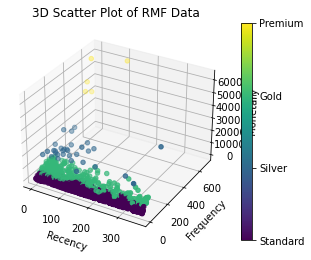

In [84]:
# Create a new figure and axis
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(rmf_data['Recency'], 
                     rmf_data['Purchase_Freq'], 
                     rmf_data['Monetary'], 
                     c=rmf_data['kmean_cluster'], 
                     cmap='viridis')
color_bar = plt.colorbar(scatter)
color_bar.set_ticks(range(len(kmean_cluster_map)))
color_bar.set_ticklabels(['Standard', 'Silver', 'Gold','Premium'])

# Set labels and title
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
ax.set_title('3D Scatter Plot of RMF Data')

# Show the plot
plt.show()


In [80]:
# Create a trace for the 3D scatter plot
trace = go.Scatter3d(
    x=rmf_data['Recency'],
    y=rmf_data['Purchase_Freq'],
    z=rmf_data['Monetary'],
    mode='markers',
    marker=dict(
        size=8,
        color=rmf_data['kmean_cluster'],  # Color by kmean_segment
        colorscale='Viridis',             # Use Viridis colormap
        opacity=0.8
    )
)

# Create layout for the plot
layout = go.Layout(
    scene=dict(
        xaxis=dict(title='Recency'),
        yaxis=dict(title='Frequency'),
        zaxis=dict(title='Monetary')
    ),
    title='Interactive 3D Scatter Plot of RMF Data'
)

# Combine trace and layout to create a figure
fig = go.Figure(data=[trace], layout=layout)

# Display the interactive plot
fig.show()

# Customer Lifetime Value

Predicting Customer Lifetime Value (Low Value/Medium Value/High Value): <br>
1. Define dependent variable with categories low value, medium value, high value
using customer revenue.
2. Perform Classification model
Cross-Selling (Which products are selling together)
3. Exploratory analysis & market basket analysis to understand which of items can be bundled together.

## LTV Prediction

In [121]:
LTV_table= all_customer_discount_and_price_tax_table[['CustomerID','Product_Category',
                                                     'Quantity', 'Revenue','Invoice_Value']]
LTV_table= pd.merge(LTV_table, all_customer, how='left', on='CustomerID')

In [125]:
q1=LTV_table['Revenue'].quantile(0.25)
q3=LTV_table['Revenue'].quantile(0.75)

IQR= q3-q1
factor=2.5
lower_bound= q1-IQR*factor
upper_bound= q3+IQR*factor

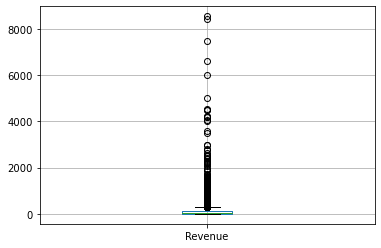

In [131]:
pd.DataFrame(LTV_table['Revenue']).boxplot()
plt.show()

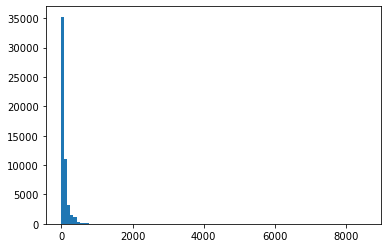

In [138]:
plt.hist(pd.DataFrame(LTV_table['Revenue']), bins=100)
plt.show()

In [126]:
q1

10.872

In [128]:
upper_bound

389.32

In [122]:
LTV_table['Revenue_segment'] = pd.cut(LTV_table['Revenue'], bins=[0, 1000, 5000, float('inf')],
                              labels=['Low Value', 'Medium Value', 'High Value'])

In [123]:
LTV_table.Revenue_segment.value_counts()

Low Value       52808
Medium Value      111
High Value          5
Name: Revenue_segment, dtype: int64

In [146]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

In [152]:
# Select features and target variable
X = LTV_table[['Recency', 'Purchase_Freq', 'Monetary']]
Y = LTV_table['Revenue_segment']

X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42, stratify=Y)

# scaling across features 
scaler= StandardScaler()
X_trained_scaled= scaler.fit_transform(X_train)
X_test_scaled= scaler.transform(X_test)



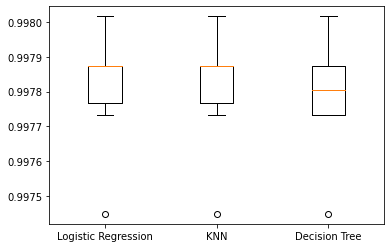

In [150]:
models={
  "Logistic Regression": LogisticRegression(), 
  "KNN": KNeighborsClassifier(),
  "Decision Tree": DecisionTreeClassifier()}

result=[]

for model in models.values():  
    kf = KFold(n_splits=6, random_state=42, shuffle=True)
    cv_result = cross_val_score(model, X_trained_scaled, y_train, cv=kf)
    result.append(cv_result)

plt.boxplot(result, labels=models.keys())  
plt.show()

In [156]:
for name, model in models.items():
    
    model.fit(X_trained_scaled, y_train)
    test_score= model.score(X_test_scaled, y_test)
    print(name, test_Score)

Logistic Regression 0.9978271138403401
KNN 0.9978271138403401
Decision Tree 0.9978271138403401


In [159]:
#Rsquared
model= LogisticRegression()
model.fit(X_trained_scaled, y_train)
y_pred = model.predict(X_test_scaled)
print('training score:', model.score(X_trained_scaled, y_train))
print('testing score:', model.score(X_test_scaled, y_test))

training score: 0.9978034436335294
testing score: 0.9978271138403401


In [165]:
# Define a mapping from string labels to numerical values
label_to_value = {'Low Value': 1, 'Medium Value': 2, 'High Value': 3}

# Convert string labels to numerical values
y_train_numeric= [label_to_value[label] for label in Y_train]
y_test_numeric = [label_to_value[label] for label in Y_test]
y_pred_numeric = [label_to_value[label] for label in Y_pred]

# Calculate the mean squared error
mse = mean_squared_error(y_test_numeric, y_pred_numeric)

print("Mean Squared Error:", mse)

Mean Squared Error: 0.0020784128483703353


<b> cross validation

In [161]:
kf= KFold(n_splits=6, shuffle=True, random_state=42)
model= LogisticRegression()
cv_results= cross_val_score(model, X, Y, cv=kf)

In [162]:
# Rsqure of each fold
print(cv_results)

array([0.99863961, 0.99795942, 0.99784605, 0.99841288, 0.99761905,
       0.99637188])

In [163]:
print(np.mean(cv_results), np.std(cv_results))
print(np.quantile(cv_results,[0.025, 0.975]))

0.9978081470530497 0.000728006964836172
[0.99652778 0.99861127]


In [145]:
y_pred_prob=model.predict_proba(X_test.iloc[:,0:])
y_pred_prob[0]

array([2.05931970e-122, 9.99377506e-001, 6.22494223e-004])

** Unsolved Problem: Although having great R-squared and MSE performance, however, it's due to that majority of the data are Low revenue, so the Model learns to assign all test data to Low revenue group. Instead of finding trend on RMF patterns. 

In [163]:
ct3= pd.crosstab(y_test, y_pred)
ct3

col_0            Low Value
Revenue_segment           
Low Value            10562
Medium Value            22
High Value               1

In [161]:
from sklearn.metrics import classification_report, confusion_matrix

In [162]:
accuracy = accuracy_score(y_test, y_pred)
classification_report = classification_report(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print(classification_report)

Accuracy: 0.9978271138403401
              precision    recall  f1-score   support

  High Value       0.00      0.00      0.00         1
   Low Value       1.00      1.00      1.00     10562
Medium Value       0.00      0.00      0.00        22

    accuracy                           1.00     10585
   macro avg       0.33      0.33      0.33     10585
weighted avg       1.00      1.00      1.00     10585



/Users/christina/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/christina/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/christina/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/Users/christina/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



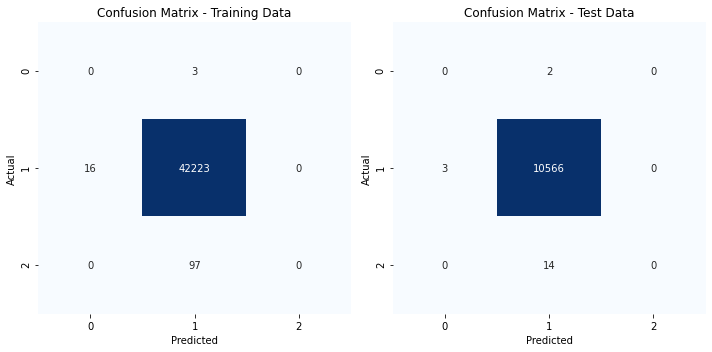

In [707]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Train the logistic regression model
model = LogisticRegression()
model.fit(X_train, Y_train)

# Predict target variable for both training and test datasets
Y_train_pred = model.predict(X_train)
Y_test_pred = model.predict(X_test)

# Compute confusion matrices
train_cm = confusion_matrix(Y_train, Y_train_pred)
test_cm = confusion_matrix(Y_test, Y_test_pred)

# Plot confusion matrix for training data
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.heatmap(train_cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix - Training Data")
plt.xlabel("Predicted")
plt.ylabel("Actual")

# Plot confusion matrix for test data
plt.subplot(1, 2, 2)
sns.heatmap(test_cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix - Test Data")
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.tight_layout()
plt.show()


set Low, Medium and High according to the Area under Curve? 

(0.0, 500.0)

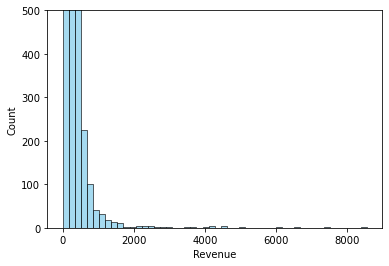

In [624]:
sns.histplot(data=LTV_atable, x='Revenue', bins=50, color='skyblue', 
             edgecolor='black')
plt.ylim(0, 500)

<b> Hyperparameters Tunning (?)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from sklearn.svm import SVC

In [ ]:
kf= KFold(n_splits=5, shuffle= True, random_state=42)
param_grid={
  #"alpha": np.arange(0.0001, 1, 10),
  'C': uniform(0.1, 10),  # Uniform distribution between 0.1 and 10
  'kernel': ['linear', 'rbf', 'poly'],
  'gamma': ['scale', 'auto'] + list(np.logspace(-3, 3, 50))
}

randomized_search= RandomizedSearchCV(estimator=SVC(), 
                                      param_distributions=param_grid, 
                                      cv=kf, n_iter=20)
#n_iter- determines number of hyper parameters tested
randomized_search.fit(X_train, y_train)
print(randomized_search.best_params_, randomized_search.best_score_)

In [ ]:
best_params_rand = randomized_search.best_params_
best_model_rand = randomized_search.best_estimator_

# Evaluate the best model
y_pred_best_rand = best_model_rand.predict(X_test)
accuracy_best_rand = accuracy_score(y_test, y_pred_best_rand)
print(f"Best SVM Accuracy: {accuracy_best_rand:.2f}")
print(f"Best Hyperparameters: {best_params_rand}")

Ridge

In [169]:
from sklearn.linear_model import Ridge, Lasso
scores=[]
for alpha in [0.1, 1.0, 10.0, 100.0, 1000.0]:
    ridge=Ridge(alpha=alpha)
    ridge.fit(X_train, y_train_numeric)
    y_pred= ridge.predict(X_test)
    scores.append(ridge.score(X_test, y_test_numeric))

print(scores)

[-0.00027789002113265404, -0.00027788988865928843, -0.0002778885639256323, -0.0002778753166405856, -0.00027774284886739053]


<b> Feature Selections: Purchase_Frequency> Monetary, Recency can be removed (not in real RMF heuristic method, but in KMean clustering)

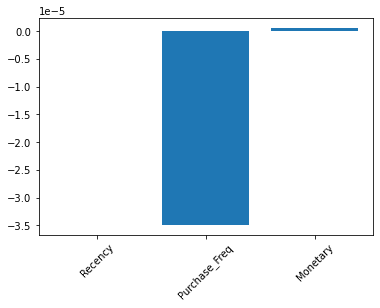

In [179]:
# Create an instance of the Lasso model
lasso = Lasso(alpha=0.1)

# Fit the Lasso model to the training data
lasso.fit(X_train, np.array(y_train_numeric))
lasso_coef = lasso.coef_
names=X_train.columns
# Assuming names contains the names of the features
plt.bar(names, lasso_coef)
plt.xticks(rotation=45)
plt.show()

## Bundle- Cross Selling

reference: https://rasbt.github.io/mlxtend/user_guide/frequent_patterns/apriori/

In [219]:
basket = all_customer_discount_and_price_tax_table.groupby(['Transaction_ID', 'Product_Category'])['Quantity'].sum().unstack().fillna(0)

# Convert quantities to binary values (1 if item is in the transaction, 0 otherwise)
basket[basket > 0] = 1

# Apply Apriori algorithm to find frequent itemsets
frequent_itemsets = apriori(basket, min_support=0.03, use_colnames=True)

# Extract association rules
association_rules_df = association_rules(frequent_itemsets, metric='lift', min_threshold=0.5)

# Interpret the association rules and identify products to bundle

# For example, to identify items that are frequently purchased together:
frequent_itemsets['itemsets'].apply(lambda x: list(x))

0                [Apparel]
1                   [Bags]
2              [Drinkware]
3              [Lifestyle]
4                   [Nest]
5               [Nest-USA]
6                 [Office]
7     [Apparel, Drinkware]
8     [Lifestyle, Apparel]
9        [Apparel, Office]
10     [Drinkware, Office]
11     [Lifestyle, Office]
Name: itemsets, dtype: object

In [222]:
#Every Transaction contains how many items (by category)
#unstack into dummy coding (one-hot dataframe)
quantity_dummycoding = all_customer_discount_and_price_tax_table.groupby(
    ['Transaction_ID', 'Product_Category'])['Quantity'].sum().unstack().fillna(0)
#quantity_dummycoding.head()
quantity_dummycoding[quantity_dummycoding > 0] = 1

In [226]:
quantity_dummycoding.head()

Product_Category  Accessories  Android  Apparel  Backpacks  Bags  Bottles  \
Transaction_ID                                                              
16679                     0.0      0.0      0.0        0.0   0.0      0.0   
16680                     0.0      0.0      0.0        0.0   0.0      0.0   
16681                     0.0      0.0      0.0        0.0   0.0      0.0   
16682                     0.0      0.0      1.0        0.0   1.0      0.0   
16684                     0.0      0.0      0.0        0.0   0.0      0.0   

Product_Category  Drinkware  Fun  Gift Cards  Google  Headgear  Housewares  \
Transaction_ID                                                               
16679                   0.0  0.0         0.0     0.0       0.0         0.0   
16680                   0.0  0.0         0.0     0.0       0.0         0.0   
16681                   0.0  0.0         0.0     0.0       0.0         0.0   
16682                   1.0  0.0         0.0     0.0       0.0         0.0   
16684                   0.0  0.0         0.0     0.0       0.0         0.0   

Product_Category  Lifestyle  More Bags  Nest  Nest-Canada  Nest-USA  \
Transaction_ID                                                        
16679                   0.0        0.0   0.0          0.0       1.0   
16680                   0.0        0.0   0.0          0.0       1.0   
16681                   0.0        0.0   0.0          0.0       0.0   
16682                   0.0        0.0   0.0          0.0       0.0   
16684                   0.0        0.0   0.0          0.0       1.0   

Product_Category  Notebooks & Journals  Office  Waze  
Transaction_ID                                        
16679                              0.0     0.0   0.0  
16680                              0.0     0.0   0.0  
16681                              0.0     1.0   0.0  
16682                              0.0     1.0   0.0  
16684                              0.0     0.0   0.0

In [ ]:
# Sum the values of each row greater than 1
row_sum_greater_than_1 = (dummy_df > 1).sum(axis=1)

# Select rows where the sum is greater than 2
rows_with_more_than_2_values = dummy_df[row_sum_greater_than_1 > 2]


In [230]:
quantity_dummycoding>0

Product_Category  Accessories  Android  Apparel  Backpacks   Bags  Bottles  \
Transaction_ID                                                               
16679                   False    False    False      False  False    False   
16680                   False    False    False      False  False    False   
16681                   False    False    False      False  False    False   
16682                   False    False    False      False  False    False   
16684                   False    False    False      False  False    False   
...                       ...      ...      ...        ...    ...      ...   
48493                   False    False    False      False  False    False   
48494                   False    False    False      False  False    False   
48495                   False    False    False      False  False    False   
48496                   False    False    False      False  False    False   
48497                   False    False    False      False  False    False   

Product_Category  Drinkware    Fun  Gift Cards  Google  Headgear  Housewares  \
Transaction_ID                                                                 
16679                 False  False       False   False     False       False   
16680                 False  False       False   False     False       False   
16681                 False  False       False   False     False       False   
16682                 False  False       False   False     False       False   
16684                 False  False       False   False     False       False   
...                     ...    ...         ...     ...       ...         ...   
48493                 False  False       False   False     False       False   
48494                 False  False       False   False     False       False   
48495                 False  False       False   False     False       False   
48496                 False  False       False   False     False       False   
48497                 False  False       False   False     False       False   

Product_Category  Lifestyle  More Bags   Nest  Nest-Canada  Nest-USA  \
Transaction_ID                                                         
16679                 False      False  False        False     False   
16680                 False      False  False        False     False   
16681                 False      False  False        False     False   
16682                 False      False  False        False     False   
16684                 False      False  False        False     False   
...                     ...        ...    ...          ...       ...   
48493                 False      False  False        False     False   
48494                 False      False  False        False     False   
48495                 False      False  False        False     False   
48496                 False      False  False        False     False   
48497                 False      False  False        False     False   

Product_Category  Notebooks & Journals  Office   Waze  
Transaction_ID                                         
16679                            False   False  False  
16680                            False   False  False  
16681                            False   False  False  
16682                            False   False  False  
16684                            False   False  False  
...                                ...     ...    ...  
48493                            False   False  False  
48494                            False   False  False  
48495                            False   False  False  
48496                            False   False  False  
48497                            False   False  False  

[25061 rows x 20 columns]

In [236]:
quantity_dummycoding[quantity_dummycoding != 0].sum(axis=1)

Product_Category  Accessories  Android  Apparel  Backpacks  Bags  Bottles  \
Transaction_ID                                                              
16679                     NaN      NaN      NaN        NaN   NaN      NaN   
16680                     NaN      NaN      NaN        NaN   NaN      NaN   
16681                     NaN      NaN      NaN        NaN   NaN      NaN   
16682                     NaN      NaN      1.0        NaN   1.0      NaN   
16684                     NaN      NaN      NaN        NaN   NaN      NaN   
...                       ...      ...      ...        ...   ...      ...   
48493                     NaN      NaN      NaN        NaN   NaN      NaN   
48494                     NaN      NaN      1.0        NaN   NaN      NaN   
48495                     NaN      NaN      NaN        NaN   NaN      NaN   
48496                     NaN      NaN      NaN        NaN   NaN      NaN   
48497                     NaN      NaN      NaN        NaN   NaN      NaN   

Product_Category  Drinkware  Fun  Gift Cards  Google  Headgear  Housewares  \
Transaction_ID                                                               
16679                   NaN  NaN         NaN     NaN       NaN         NaN   
16680                   NaN  NaN         NaN     NaN       NaN         NaN   
16681                   NaN  NaN         NaN     NaN       NaN         NaN   
16682                   1.0  NaN         NaN     NaN       NaN         NaN   
16684                   NaN  NaN         NaN     NaN       NaN         NaN   
...                     ...  ...         ...     ...       ...         ...   
48493                   NaN  NaN         NaN     NaN       NaN         NaN   
48494                   NaN  NaN         NaN     NaN       NaN         NaN   
48495                   NaN  NaN         NaN     NaN       NaN         NaN   
48496                   NaN  NaN         NaN     NaN       NaN         NaN   
48497                   NaN  NaN         NaN     NaN       NaN         NaN   

Product_Category  Lifestyle  More Bags  Nest  Nest-Canada  Nest-USA  \
Transaction_ID                                                        
16679                   NaN        NaN   NaN          NaN       1.0   
16680                   NaN        NaN   NaN          NaN       1.0   
16681                   NaN        NaN   NaN          NaN       NaN   
16682                   NaN        NaN   NaN          NaN       NaN   
16684                   NaN        NaN   NaN          NaN       1.0   
...                     ...        ...   ...          ...       ...   
48493                   NaN        NaN   NaN          NaN       1.0   
48494                   NaN        NaN   NaN          NaN       NaN   
48495                   NaN        NaN   NaN          NaN       1.0   
48496                   NaN        NaN   NaN          NaN       1.0   
48497                   NaN        NaN   NaN          NaN       1.0   

Product_Category  Notebooks & Journals  Office  Waze  
Transaction_ID                                        
16679                              NaN     NaN   NaN  
16680                              NaN     NaN   NaN  
16681                              NaN     1.0   NaN  
16682                              NaN     1.0   NaN  
16684                              NaN     NaN   NaN  
...                                ...     ...   ...  
48493                              NaN     NaN   NaN  
48494                              NaN     NaN   NaN  
48495                              NaN     NaN   NaN  
48496                              NaN     NaN   NaN  
48497                              NaN     NaN   NaN  

[25061 rows x 20 columns]

In [242]:
non_zero_counts = (quantity_dummycoding != 0).sum(axis=1)
morethan2products = quantity_dummycoding[non_zero_counts > 2]
threshold=len(morethan2products)/len(quantity_dummycoding)

In [243]:
threshold

0.08599018395115918

In [250]:
#threshold=0.08599018395115918
frequent_itemsets = apriori(quantity_dummycoding, 
                            min_support=0.03, use_colnames=True)

In [251]:
frequent_itemsets

support              itemsets
0   0.324369             (Apparel)
1   0.061650                (Bags)
2   0.100714           (Drinkware)
3   0.068313           (Lifestyle)
4   0.078768                (Nest)
5   0.463908            (Nest-USA)
6   0.140697              (Office)
7   0.045010  (Apparel, Drinkware)
8   0.033079  (Lifestyle, Apparel)
9   0.062128     (Apparel, Office)
10  0.046287   (Drinkware, Office)
11  0.035114   (Lifestyle, Office)

In [253]:
association_rules_df = association_rules(frequent_itemsets, 
                                         metric='lift')
frequent_itemsets['itemsets'].apply(lambda x: list(x))

0                [Apparel]
1                   [Bags]
2              [Drinkware]
3              [Lifestyle]
4                   [Nest]
5               [Nest-USA]
6                 [Office]
7     [Apparel, Drinkware]
8     [Lifestyle, Apparel]
9        [Apparel, Office]
10     [Drinkware, Office]
11     [Lifestyle, Office]
Name: itemsets, dtype: object

<b> Bundle sales

In [254]:
association_rules_df

antecedents  consequents  antecedent support  consequent support   support  \
0    (Apparel)  (Drinkware)            0.324369            0.100714  0.045010   
1  (Drinkware)    (Apparel)            0.100714            0.324369  0.045010   
2  (Lifestyle)    (Apparel)            0.068313            0.324369  0.033079   
3    (Apparel)  (Lifestyle)            0.324369            0.068313  0.033079   
4    (Apparel)     (Office)            0.324369            0.140697  0.062128   
5     (Office)    (Apparel)            0.140697            0.324369  0.062128   
6  (Drinkware)     (Office)            0.100714            0.140697  0.046287   
7     (Office)  (Drinkware)            0.140697            0.100714  0.046287   
8  (Lifestyle)     (Office)            0.068313            0.140697  0.035114   
9     (Office)  (Lifestyle)            0.140697            0.068313  0.035114   

   confidence      lift  leverage  conviction  zhangs_metric  
0    0.138762  1.377784  0.012342    1.044179       0.405838  
1    0.446910  1.377784  0.012342    1.221557       0.304905  
2    0.484229  1.492836  0.010921    1.309945       0.354340  
3    0.101981  1.492836  0.010921    1.037491       0.488630  
4    0.191536  1.361343  0.016491    1.062884       0.392864  
5    0.441577  1.361343  0.016491    1.209892       0.308891  
6    0.459588  3.266516  0.032117    1.590089       0.771572  
7    0.328985  3.266516  0.032117    1.340187       0.807472  
8    0.514019  3.653381  0.025503    1.768182       0.779533  
9    0.249575  3.653381  0.025503    1.241545       0.845197

# Next Purchase Prediction

Predicting Next Purchase Day (How soon each customer can visit the store (0-30 days, 30-60
days, 60-90 days, 90+ days)
<br>
1. For this, we need create dependent variable at customer level (average days per one transaction for only repeat customers and divide into groups 0-30 days, 30-60 days, 60-90 days and 90+ days) 
2. then build classification model to predict next purchase of given customer.

In [199]:
#Feature Selection
Product_vector = discount_and_price_table.groupby(
    ['CustomerID', 'Transaction_Date','Product_Category'])['Quantity'].sum().unstack().fillna(0)

Coupon_vector=discount_and_price_table.groupby(
    ['CustomerID', 'Transaction_Date','Coupon_Status'])['Discount_pct'].sum().unstack().fillna(0)

Delivery_scalar=discount_and_price_table.groupby(
    ['CustomerID', 'Transaction_Date'])['Delivery_Charges'].sum()

In [200]:
X = pd.concat([Product_vector, Coupon_vector, Delivery_scalar], axis=1)

In [202]:
pv =Product_vector.reset_index()
x= X.reset_index()
x['Time_Interval']=pv.groupby('CustomerID')['Transaction_Date'].diff().dt.days
x['To_Next_Purchase_Date']=x['Time_Interval'].shift(-1)
x['Interval_Category']= pd.cut(x['To_Next_Purchase_Date'], 
                               bins=[-1, 30, 60, 90, float('inf')], 
                               labels=['0-30 days', '31-60 days', '61-90 days', '90+ days'])
x['Num_Category']= pd.cut(x['To_Next_Purchase_Date'], 
                               bins=[-1, 30, 60, 90, float('inf')], labels=False)
#remove those who have only purchased once
x_data= x.dropna(axis=0) 

In [203]:
x_data.head()

CustomerID Transaction_Date  Accessories  Android  Apparel  Backpacks  \
2        12347       2019-11-01          0.0      0.0      2.0        0.0   
15       12383       2019-07-14          0.0      0.0     10.0        0.0   
16       12383       2019-08-24          0.0      0.0     22.0        2.0   
24       12395       2019-06-28          0.0      0.0     17.0        0.0   
33       12415       2019-07-27          0.0      0.0      1.0        0.0   

    Bags  Bottles  Drinkware  Fun  ...  Office  Waze  Clicked  Not Used  \
2    0.0      0.0        0.0  0.0  ...     1.0   0.0     60.0       0.0   
15   1.0      0.0        0.0  0.0  ...     0.0   0.0    110.0      20.0   
16   2.0      0.0        3.0  0.0  ...     6.0   3.0    320.0     100.0   
24   1.0      0.0        0.0  0.0  ...     0.0   0.0    330.0      60.0   
33   0.0      0.0        0.0  0.0  ...     0.0   0.0     10.0       0.0   

     Used  Delivery_Charges  Time_Interval  To_Next_Purchase_Date  \
2    20.0             53.70          222.0                    1.0   
15   70.0            120.99            1.0                   41.0   
16  180.0            306.91           41.0                   30.0   
24  180.0            114.00          139.0                   22.0   
33    0.0              6.00            1.0                   17.0   

    Interval_Category  Num_Category  
2           0-30 days           0.0  
15         31-60 days           1.0  
16          0-30 days           0.0  
24          0-30 days           0.0  
33          0-30 days           0.0  

[5 rows x 30 columns]

In [204]:
x_data.set_index('CustomerID',inplace=True)

In [205]:
features=x_data.iloc[:,1:-3]
depedent=x_data.iloc[:,-1]

In [206]:
X_train, X_test, y_train, y_test = train_test_split(features, depedent, test_size=0.2, random_state=42)

In [209]:
X_train_np = X_train.values
X_test_np= X_test.values

y_train_np = y_train.values
y_test_np= y_test.values

y_train_np_int = y_train_np.astype(np.int_)
y_test_np_int= y_test_np.astype(np.int_)

In [212]:
clf= SVC()
clf.fit(X_train, y_train)
y_train_pred = clf.predict(X_train_np)

In [214]:
# Assuming clf is your classifier and X_test_np, y_test_np_int are your test data
# Predictions on the training data
y_train_pred = clf.predict(X_train_np)
train_accuracy = accuracy_score(y_train_np_int, y_train_pred)
print("Training Accuracy:", train_accuracy)

# Confusion matrix for training data
train_conf_matrix = confusion_matrix(y_train_np_int, y_train_pred)
print("Training Confusion Matrix:")
print(train_conf_matrix)

# Predictions on the test data
y_test_pred = clf.predict(X_test_np)
test_accuracy = accuracy_score(y_test_np_int, y_test_pred)
print("Test Accuracy:", test_accuracy)

# Confusion matrix for test data
test_conf_matrix = confusion_matrix(y_test_np_int, y_test_pred)
print("Test Confusion Matrix:")
print(test_conf_matrix)


Training Accuracy: 0.5422885572139303
Training Confusion Matrix:
[[425   0   0   0]
 [136   3   0   0]
 [ 90   0   3   0]
 [142   0   0   5]]
Test Accuracy: 0.5445544554455446
Test Confusion Matrix:
[[110   0   0   0]
 [ 32   0   0   0]
 [ 27   0   0   0]
 [ 33   0   0   0]]


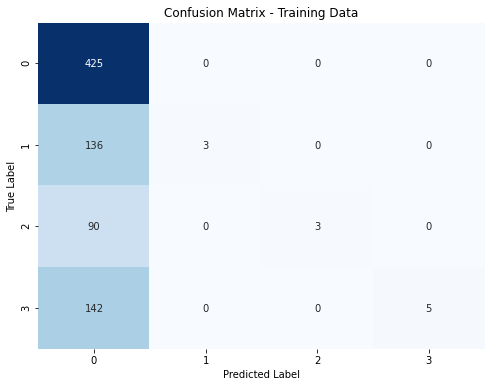

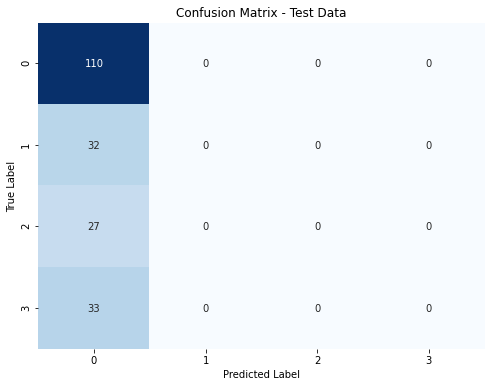

In [215]:

# Plot confusion matrix for training data
plt.figure(figsize=(8, 6))
sns.heatmap(train_conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Training Data')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Plot confusion matrix for test data
plt.figure(figsize=(8, 6))
sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Test Data')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# cohort analysis

Perform cohort analysis by defining below cohorts <br> 
1. Customers who started in each month and understand their behavior
2. Which Month cohort has maximum retention?

# Comments on the Database

Question：Different people could possibly share the same Transaction_ID? Why? 

In [217]:
discount_and_price_table.iloc[38120:38126] 

CustomerID  Transaction_ID Transaction_Date     Product_SKU  \
38120       12346           38223       2019-09-15  GGOEAAAJ080816   
38121       12748           38223       2019-09-15  GGOEAAFB035917   
38122       12748           38223       2019-09-15  GGOEGAAL010617   
38123       12748           38223       2019-09-15  GGOEGOAQ012899   
38124       12748           38223       2019-09-15  GGOEGOAQ020099   
38125       12346           38223       2019-09-15  GGOEGOAR013099   

                                     Product_Description Product_Category  \
38120   Android Men's Engineer Short Sleeve Tee Charcoal          Apparel   
38121                          Android Men's  Zip Hoodie          Apparel   
38122  Google Men's 100% Cotton Short Sleeve Hero Tee...          Apparel   
38123                            Ballpoint LED Light Pen           Office   
38124                         Four Color Retractable Pen           Office   
38125                     Google Stylus Pen w/ LED Light           Office   

       Quantity  Avg_Price  Delivery_Charges Coupon_Status Month Coupon_Code  \
38120         1      19.99              75.0          Used   Sep      SALE30   
38121         1      39.19              75.0          Used   Sep      SALE30   
38122         1      16.99              75.0          Used   Sep      SALE30   
38123         1       2.50              75.0       Clicked   Sep       OFF30   
38124         1       2.99              75.0      Not Used   Sep       OFF30   
38125         2       5.50              75.0          Used   Sep       OFF30   

       Discount_pct  
38120          30.0  
38121          30.0  
38122          30.0  
38123          30.0  
38124          30.0  
38125          30.0